In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier, cv, Pool

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier 

from sklearn.model_selection import train_test_split, learning_curve, cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from  sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
import umap
import shap

from sklearn.datasets import load_iris, fetch_covtype, load_digits, make_classification, make_blobs

# собственные библиотеки
import ml_tools as ml
import help_tools as ht
import eda_tools as eda
import imp # imp.reload
from IPython.display import display, HTML

<u>Полезные ссылки</u>  
https://habr.com/ru/companies/ods/articles/328372/ - метрики в ml  
https://habr.com/ru/companies/ods/articles/322626/ - открытый курс ml Mail.ru  
https://education.yandex.ru/handbook/ml - онлайн учебник ml, yandex  
https://catboost.ai/en/docs/ - документация по catboost

---

https://scikit-learn.org/1.5/machine_learning_map.html - choosing right estimator (map)  
https://rasbt.github.io/mlxtend/user_guide/evaluate/lift_score/ - lift score (for uplift modeling)
https://habr.com/ru/articles/760550/ - анализ ошибок модели для ее улучшения

---

#### Общие моменты

<u>Постановка задач классификации и регрессии</u>  
Имеем датасет из N объектов у которых есть x1,x2...xk признаков (они же фичи).  
У каждого объекта есть целевой признак Y (он же таргет)  

Задача ML:
сопоставление X -> Y_pred, предсказание таргета для каждого объекта по его фичам.  
Задача классификации: можество Y_pred дискретное (0, 1, ...); бинарная, когда Y_pred = (0, 1)  
Задача регрессии: Y_pred = множество действительных чисел (например предикт выручки для каждого объекта).  
  
Задача ML = задача оптимизации некоторой метрики = функции ошибок (функция потерь, <u>Loss-func</u>) считаемой  
на множестве (X, Y, Y_pred). Чем ближе Y_pred к реальной Y - тем меньше значения функции ошибок.  

Основной Loss-funс для бин. классификации = LogLoss = f(log(Y_pred), Y_pred, Y) = max функции правдоподобия  
Правдоподобие = вероятность наблюдать данные реализации случ. величин при некотором заданном распределении.
Для многоклассовой регрессии используется другая метрика - MultiClass.

Основной Loss-func для регрессии = RMSE (root_mean sq err) = sum(y^2-y_pred^2)/N  
Подробнее про него можно чекнуть в разделах AB&CI, на нем построен МНК метод.

Альтернативные функции потерь:  
MAE = sum(|y-y_pred|)/N - меньше штраф за сильные отклонения (нет квадрата) - для выборок большим размахом  
MAPE = sum(|y-y_pred/y|)/N - относительные отклонения, когда важен порядок, а не масштаб  
Для разных задач Loss_func(X, Y, Y_pred) могут отличаться - большой список возможных функций здесь:   https://catboost.ai/en/docs/references/training-parameters/common  
Можно писать свою функцию учитывая необходимость штрафов за ошибки разного рода.

<u>Переобучение и валидация</u>  
Если скормить модели данные X,Y -> то она может просто запомнить маппинг X->Y  (Y_pred = Y; Lossfunc = 0)  
Но для нового датасета X_new вырастет число ошибок = переобучение.  
  
Борьба с переобучением - подбор <u>гиперпараметров</u> модели, регулируя ее сложность относительно данных.
Пример: модель = полином N степени, чем выше N тем выше риск переобучения итд.  
Модель должна уловить общие закономерности данных, а не запомнить датасет.  
  
При подборе гиперпараметров - необходима валидация = оценка на тестовом датасете качества модели.  
Наиболее корректный способ кросс-валидация = делим выборку X на K частей (фолдов),  
далее делаем K иттераций в каждой из которых = модель учится на K-1 части, валидируется на оставшейся.  

Метрики качества обучения построены на принципе оценки ошибок первого и второго рода.  
Про возможные метрики см подробнее ниже в разделе "Метрики качества"  
  
<u>Кривые обучения</u>  
Чем более сложная модель - тем больше она может уловить закономерностей, но и выше шанс переобучения.  
Сложность модели зависит от ее гиперпараметров. Чтобы контролировать эту зависимость можно строить  
learning curve - кривые обучения. Это зависимость метрики качества (одно из возможных) полученной на  
train и test датасетах от значения гиперпараметров (или от размеров выборки).
  
Сложность разных моделей определяется разными гиперпараметрами. Например:  
Для регрессий может быть степенью полинома над признаками.    
Для kNN методов - кол-вом соседей и коэф. зависимости решения от расстояния  
Для деревьев - глубиной дерева и макс. кол-вом объектов в конечных листах.  
  
<u>Поиск минимума функции потерь</u>  
В процесе обучения алгоритм подбирает веса модели, минимизируя заданную функцию потерь.  
Для линейных моделей поиск минимума LossFunc достигается методом градиентного спуска.  
На каждом шаге численно оценивается градиент grad(LossFunc) по весам модели и идет подкрутка весов  
в сторону -grad = направлен к локальному минимуму функции (если повезет, будет глобальный).  
  
Когда весов очень много - считать полный градиент на каждой иттерации дорого, поэтому  
применяют стохастический градиентный спуск (SGD).  
Вместо всего датасета берется батч (некоторый случайный семпл), по нему вдоль случайного  
веса (или группы весов) вычисляется grad_est и делается шаг по нему. Для сходимости к точке минимума  
здесь требуется больше шагов, однако одна иттерация занимает меньше времени и можно подобрать баланс,  
когда обучение будет происходить быстрее.
  
<u>Bias-variance trade-off</u>  
Предположим, мы обучаем модель на случайных тренировочных данных предсказывать случайные тестовые таргеты.  
Если в реальности справедлива функция y_real = f(X) - то в на выборке теста y = f(X) + noise.  
Если обучаемся на случайной тренировочной выборке, то также получаем оценку f_est реальной f.  
bias = avg(f_est - f) - насколько смещенными получаются оценки, var = avg((f_est - avg(f_est))^2)  
(y - f_est)^2 = (f_est - f)^2 + 2 * (f-f_est) * noise + noise^2  
(y - f_est)^2 = (f_est - avg(f_est))^2 + 2 * (f_est - avg(f_est)) * (avg(f_est) - f) + (avg(f_est) - f)^2 + 2 * (f-f_est) * noise + noise^2  
avg((y - f_est)^2) = var(f_est) + 0 + bias^2 + 0 + avg(noise^2)  
  
Объяснение уравнения:  
финальная ошибка предикта на тестовых данных avg((y - f_est)^2) складывается из компонент:  
- var(f_est) = шум самого построенного предикта
- bias = систематическая неточность предикта относительно реальности
- noise = шум таргета y который не описывается моделью (внешние другие факторы)

Уравнение лишь декомпозирует финальную ошибку. При усложнении модели обычно bias -> 0,  
при этом растет риск переобучения, поэтому var растет (чувствительность к конкретным train-данным)


#### Линейные модели

https://education.yandex.ru/handbook/ml/article/linear-models  

Для общей задачи поиска func: func(X) = Y_pred можно использовать лин. функции  
func = w1 * x1 + w2 * x2 + ...  = задачи линейной регрессии и классификации.  
  
Допущение о данных:
1. существует гиперплоскость, которая их эффективно разделяет  
2. гомоскедастичность остатков (=дисперсия ошибок равномерная).  
Пример: датчик скорости авто ошибается одинаково для больших и малых скоростей  
Тогда разброс значений модели постоянен для разных диапазонов данных.
3. отсутствие сильных выбросов (т.к модель минимизирует среднее = не робастное)  
4. слабая попарная корреляция признаков (иначе = сингулярность и неустойчивость решения) - см ниже

<u>Линейная регрессия</u>  
Подробнее про регрессию можно чекнуть в AB&CI тетрадке, а также в Статистика.  
Некоторые важные особенности линейной регрессии:
1. Может отражать даже нелинейные зависимости вроде y = x1^2 + x2^3 ..., если  
сделать замену переменных x_new = x1^2 итд (полиномиальные регрессии или другого рода).  
2. Выдает веса w1,... обладающие интерпретируемостью. Но важно учитывать  
зависимость регрессии от масштаба данных (можно их нормализовывать итд - раздел Препроцессинг)
3. Решается аналитически (МНК), но обращение матрицы X - вычислительно сложная продцедура,  
поэтому применяют методы градиентного спуска = задаем веса W, считаем ошибки (Y-Y_pred), оцениваем градиент  
grad_W в сторону минимизации LossFunc, корректируем веса (шаг dW = learning rate) итд.  
Стохастичекий спуск = оцениваем градиент по случ. w_i (не по всем) -> больше шагов, но быстрее сходится.  
Кроме того, grad_W примерно можно оценивать не по всем данным X, а по случайной выборке.  
Т.е стохастичность и по колонкам и по кол-ву строк в X.
4. Ломается при det_X ~ 0 = коррелирующие  признаки X (т.к возникает множественность оптимальной прямой разбиения = сингулярность). Если признаки примерно коррелирующие, т е det_X ~ 0, это тоже проблема:
малое изменение признаков x -> большие изменения в предикте -> рост весов w (важность искуственно завышается)
5. Высокие отдельные веса w - высокое внимание модели к этим признакам -> сигнал к переобучению, т к 
небольшие изменения этих признаков приведут к сильному движению в прогнозах. При этом, при мультиколлинеарности высокие веса не будут отражать реальную важность признаков для предсказания. 
6. Для борьбы с проблемой высоких весов (aka переобучения здесь) - используют <u>регуляризацию</u>.  
Регуляризация = штраф модели за высокие значения отдельных весов: Loss_func_r = Loss_func + k * L    
k = коэф. регуляризации; L = L1, L2; L1 = |w1| + |w2| + ...; L2 = w1^2 + w2^2 + ...  
Матричная интерпретация: смещаем матрицу M=X^TX на k * I, чтобы det_M > 0. Решение менее точное,  
но без вычислительных проблем с сингулярностью. k - гиперпараметр, сила регуляризации  
PS. В основном хорошо работает L=L2, L1 не дифференциируется (сложнее искать grad), зато обнуляет  
неважные признаки (или коррелированные), что может быть полезно для прореживания весов (сокращение кол-ва).  
  
<u>Линейный классификатор</u>  
Идея в том, чтобы предсказывать y_pred = f(X) = (0, 1, ...)  
Loss_func = RMSE подходит плохо, так как плохо штрафует за близкие по X объекты с разными таргетами.  
У разделяющей поверхности сумма квадратов расстояний может быть большим, это ок.  
Основа функции потерь для классификатора M = margin = sign(y_pred * y) * (w * X) - <u>отступ</u>  
Это расстояние до плоскости разделения со знаком верности прогноза. abs(M) = уверенность классификатора.

Loss_func = f(M). Варианты классификаторов в зависимости от M:
1. Loss_func = sum(max(0, 1 - M)) = SVM (метод опорных векторов).  
Делаем плоскость равноудаленной от обоих разделяемых классов -> максимизируем сильную корректную уверенность.   
Был популярен в 60-х годах - мало параметров для настройки, точное мат. решение.
2. Loss_func = logit_func(M) = логистическая регрессия.  
Пусть модель дает нам вероятность того, что y = 1. Тогда можно максимизировать правдоподобие -  
шанс получить данные y(X). для объекта при условии вероятности для него p(X)  
Свяжем вероятность с отступом M для каждого объекта: M = logit(p) = log(p / 1-p)  
p/1-p = функция шансов; log - маппинг пространства 0;inf в пространство -inf;inf.  
Тогда p = sigmoida(M) -> loss_func = правдоподобие(p1, p2...) = правдоподобие(sigmoida(M)...)  
Логистическая <u>регрессия</u> потому что мы предсказываем не классы, а вещественные логиты.  
threshold - по которому вероятности proba сопоставляется класс 0;1 = гиперпараметр.  
  
<u>Множественная классификация</u>  
Пусть у нас есть множество классов, y_pred = 0, 1, 2, ... K  
Наиболее корректный вариант обучения - модель "все-против-всех"  
Обучаем K^2 классификаторов разделяющих классы i-j (все возможные пары).  
Получаем предикт по объекту X от всех пар - голосованием присваиваем таргет класса-победителя.

#### Метрические модели

Метод классификации или регрессии, при котором таргет тестовой точки выстраивается по ее <u>соседям</u> в  
признаковом пространстве из тренировочной выборки. (проще говоря: скажи мне кто твой друг).  
Фаза обучения отсутствует - тренировочная выборка запоминается, далее вычисления происходят для каждого  
тестового семпла (поиск соседей, оценка итогового таргета) = ленивая модель.  
  
Допущение о данных:  
1. смысловая близость объектов эквивалентна метрической (метрику расстояния можно вычислять)  
2. произвольные законы распределения данных, классов  
3. наличие большого кол-ва данных при большом кол-ве признаков X (проклятие размерности)  
Причина: чем выше размерность - тем сложнее в фикс. окрестности найти для семпла соседа  
    
Плюсы алгоритмов:
1. высокая обобщающая способность и точность (часто используют как бейзлайны)  
2. хорошая интерпретируемость  
  
Минусы:
1. при большом кол-ве данных вычислительно сложная процедура
2. не для всех данных можно подобрать метрику расстояния  

Основные типы расстояний (здесь a,b - признаки двух объектов выборки в пространстве X):  
1. Евклидово = (b^2-a^2) + ... 
2. Манхеттен = |b-a| + ... (менее чувствителен к выбросам, тк нет квадрата)
3. Косинус = (a,b)/|a||b| (не зависит от норм векторов.  
Хорошо напр. в текстах, где схожесть объекта не изменится,  
если один текст станет в два раза длиннее предыдущего  
  
Алгоритмы поиска соседей по расстояниям:
1. Прямой = считаем расстояния для всех пар (a,b), отбираем K самых близких = очень долго
Также можно воспользоваться бинарной сортировкой за logN по признакам и далее искать соседей в данном поле.
2. Примерный = находим достаточно близкие объекты пусть и не максимальные. Метод случайного дерева:  
в выборке берем случ. два семпла, разделяем их гиперплоскостью, выбираем случ. полуплоскость, в ней повторяем иттерацию. Останавливаем иттерации тогда, когда в полученных разбиенях пространства (кластерах) <K семплов.  
Точки в каждом таком кластере называем соседями.  
  
Оценка таргета семпла по его соседям:  
1. Самый частый таргет у соседей (прямой алгоритм, но без оценки расстояний)  
2. Средневзвешенный на расстояния до соседей таргет
3. Таргет взвешенный на функцию K(R/w), R = расстояние; w = ширина. K = ядро алгоритма (разные варианты)  
w - гиперпараметр, задающий сложность алгоритма (по аналогии со степенью полиномов)  
Чем больше w - тем меньше зависимость решения от расстояния -> алгоритм более простой  
Чем меньше w - расстояние важнее -> модель умнее запоминает выборку, но есть риск переобучения.  
  
По аналогии с классификацией - возможна ядерная регрессия - даем взвешенные на расстояния  
до соседей предикты непрерывного таргета для разных объектов.  
  
<u>LSH (Locality-sensitive hashing) алгоритмы</u>  
Идея: поиск хеш функции для каждого типа расстояния, таких что, чем меньше R(a,b), тем выше вероятность  
коллизии в пространстве хешей P(hash(a) = hash(b))  
Подбирая гиперпараметры для хеш функций, можно регулировать разницу в вероятностях коллизий в зависимости от R.  
  
<u>Алгоритмы на графах HNSW = Hierarchical navigable small world</u>  
Идея - записать все данные тренировочной выборки в граф, удовлетворящий условиям:
1. Между любыми двумя точками существует короткий путь
2. Средняя степень вершины мала
Пример: правило 5 рукопожатий - от любого человека, до другого - часто менее 5 рукопожатий  
  
Далее при поиске соседей для тестового объекта X:  
1. выбираем произвольный объект в графе
2. идем в сторону соседа, который ближе к тестовому объекту в пространстве
3. повторяем так K "рукопожатий" пока не дойдем до близких соседей

In [13]:
# В sklearn поддерживается алгоритм поиска k ближ соседей через регрессию и классификацию 
# вид алгоритма - брут-форс, дерево итд.  
from sklearn.neighbors import KNeighborsClassifier

# Пример данных X здесь двумерное пространство точек arr(obj1, obj2, ...); y = таргеты
X_train = [[1, 2], [2, 3], [3, 4], [5, 6]]
y_train = [0, 0, 1, 1]


knn = KNeighborsClassifier(n_neighbors=2, algorithm = 'auto', metric = 'manhattan')
# knn_regressor = KNeighborsRegressor(n_neighbors=3) # аналогично на вещественной выборке Y
knn.fit(X_train, y_train) # запомнили тренировочную выборку

# ленивые вычисления с поиском ближ соседей по расстоянию metric и методу algorithm
new_data = [[2, 2], [10, 5]]
prediction = knn.predict(new_data)
distances, indices = knn.kneighbors(new_data)
print('предсказываемые Y ', prediction)
print('расстояния до ближ соседей для каждой тестовой точки ', distances)
print('индексы ближ соседей в выборке X_train ', indices)

предсказываемые Y  [0 1]
расстояния до ближ соседей для каждой тестовой точки  [[1. 1.]
 [6. 8.]]
индексы ближ соседей в выборке X_train  [[0 1]
 [3 2]]


#### Решающие деревья

https://education.yandex.ru/handbook/ml/article/reshayushchiye-derevya  
https://habr.com/ru/companies/ods/articles/322534/  
  
Решающее дерево = граф, в узлах которого логический предикат f(X), а листья которого осуществляют  
маппинг таргета отнесенного к ним объекта к определенному классу или значению (для регрессии).  
Если для объекта f(X) > 0 - то спускаемся в правый узел и рекурсивно спускаемся до листа. Если f(X) < 0,   
то спускаемся в левый узел и аналогично повторяем проверки.  
  
Простой сценарий f(X) = x_i - thr. Такой узел разбивает пространство признака x_i объекта на две части.  
В общем случае - данное дерево рекурсивно разбивает пространство X гиперплоскостями на многомерные  
прямоугольники. Объекту попадающему в определенный прямоугольник - присваивается характерный таргет.  
  
Если обучать дерево без ограничений, то оно может дойти до сценария "один лист = один объект", полностью  
запомнит обучающую выборку (переобучение). Контролировать это можно через критерий останова Stop.
  
<u>Обучение (построение) дерева</u>  
  
Общая процедура:  
1. Имеем M объектов выборки train: X_m = a1,a2, ... в некотором узле
2. Если критерий останова Stop(X_m) = true - объявляем множество X_m листом.    
Считаем таргет листа leaf_target = get_target(X_m)
3. Если Stop(X_m) = False, то ищем разбиение (сплит) X_m = X_l + X_k, чтобы    
максимизировать критерий ветвления Branch(X_m, l, k).  
4. Рекурсивно повторяем шаги в множествах X_l, X_k.
  
Варианты Stop(X_m):  
- len(X_m) < max_leaf_size  
- tree_depth > max_tree_depth  
- любой сплит k;l увеличивает критерий Branch(X_m,k,l) < threshold  
Критерий останова = по сути <u>регуляризация</u> деревьев (штраф для предотвращения переобучения).  
  
Варианты get_target(X_m):
- наиболее частотный таргет среди X_m (классификация)
- среднее, медиана итд по таргетам X_m (регрессия)
  
Критерий ветвления Branch.  
Branch = F(X_m) - (wl * F(X_l) + wk * F(X_k)); wq = q/m (веса).  
F(X_m) - функция потерь на множестве объектов (ее мы по сути минимизируем сплитованиями).  
Т.е Branch = насколько снизилась функция потерь в системе после сплитования.  

Варианты функции потерь F(X):  
1. Энтропия F(X) = S = -SUM(p * log2p). p_i = доля объектов класса i.  
Энтропия = мера неопределенности и полной информации.  
Пример: коробка с цветными шариками - N штук, X цветов. Случайно достаем шарик.  
Cколько надо бит информации чтобы закодировать возможные его состояния?  
Если все шарики одного цвета, то не узнаем ничего нового -> S = 0. Макс. инфы - равномерное распр.    
    
    
2. Функция Джинни F(X) = G = 1 - SUM(p^2); p_i = доля объектов класса i.  
G = вероятность того что два случайно выбранных объекта принадлежат разным классам  
G = 1 - p1 * p1 - p2 * p2 - ... (т.е 1 - вероятность что принадлежат одному)  
Чем меньше эта вероятность - тем выше однородность множества.  
Если все объекты одного класса, то G=0 (полная однородность).  

  
<u>Категориальные данные</u>  
Для Q значений категориального признака - получается 2^Q-1 возможных сплитов, это очень много для перебора.  
Теорема: каждому значению q из Q можно противопоставить вещественное q_ = частота встречаемости q.  
Оптимизация такого множества решит задачу оптимизации разбиений по исходным признакам q.  
  
PS. Существует много эвристик для построения деревьев - при этом нет строгой теории по их быстрому  
оптимальному построению. Это NP-неполная задача. Однако, примерные разбиения деревьев построенные на  
минимизации энтропии или критерия Джинни в листьях - неплохо справляются по метрикам ML.

#### Ансамбли

Ошибка алгоритма F на выборке X складывается из компонент err(F, X) = bias + variance + noise.  
bias = среднее смещение предсказаний по всем выборкам X (систематическая ошибка),  
var = смещение оценок в зависимости от конкретной выборке X из общего распределения (устойчивость),  
noise = неустранимый шум данных.  
К примеру, когда F - переобучилась, у нее bias -> 0, но очень большой variance  
(запоминает выборки -> мало на каждой ошибается, но при этом крайне не устойчива).  
  
Ансамбли = модель F = F(a1, a2, ...) принимающая решение на базе группы более простых моделей ai.  
Базовая теорема ансамбля = теорема присяжных. Пусть каждый присяжный принимает решение (0,1) с  
вероятностью принять его верно p>0.5. Тогда среднее решение по группе N старейшин p_group->1 при N->inf.  
Идея ансамбля - снизить var или bias, уменьшив тем самым общую ошибку (с noise ничего не поделаешь).  

<u>Bagging - bootstrap aggregation</u>  
Пусть X - обучающая выборка. Семплируем из нее с возвращением K выборок X: X1, X2, ...; len(Xi) = len(X).  
Обучаем модели a1.fit(X1), a2.fit(X2), ... -> F = 1/k * (a1 + a2 + ...)  
var(F) = 1/k * var(a) предполагая что решения a1, a2, ... <u>независимы (не коррелируют)</u>  
На этом построены алгоритмы лесов (тогда a1, a2, ... - деревья решений). 
  
Так как выборки X1, X2, ... из общго источника -> в реальности corr(ai, aj) > 0.  
Понизить корреляцию можно рандомизацией набора признаков по которым ищется оптимальный сплит.  
То есть по сути мы добавляем случайность в поведение a1, a2, ... хоть и на связных данных Xi.  
Берем выборку X1 -> a1 на каждом шаге берем случ. подмножество признаков - ищем сплит итд.  
Итоговый алгоритм F = <u>random forest (случайный лес)</u>
  
В бэггинге на вход ансамблю разумно подавать алгоритмы с малым смещением и большим разбросом (разброс потом  
снижаем). Для случайного леса - можем обучить их достаточно глубоко (даже переобучить)  
Дальше берем большое кол-во деревьев k~10^4 снижая variance.  

Размер случайного подмножества признаков для обучения одного дерева ~sqrt(N) всех признаков.  
Баланс между отсутствием корреляции между деревьями и слабой предсказательной силой дерева.

<u>Boosting</u>  
В бэггинге алгоритмы a1, a2, ... учатся независимо параллельно, а в бустинге - последовательно.  
Идея: каждый следующий алгоритм ai корректирует ошибки предыдущего алгоритма a(i-1).  
  
Здесь мы учимся на ошибках предыдущего дерева -> корректируем смещение. Поэтому на вход ансамблю  
разумно подавать алгоритмы с малым разбросом и большим смещением - например, неглубокие деревья.  
Деревья глубины 2-3 стабильны (малый variance) и быстро учатся.  
Основной алгоритм - градиентный бустинг (на практике он даже мощнее случайного леса).  
  
<u>Stacking</u>  
Более сложные методы, в которых в ансамбли объединяются модели разной природы (леса, метрические итд).

#### Градиентный бустинг

https://habr.com/ru/companies/ods/articles/327250/  
https://education.yandex.ru/handbook/ml/article/gradientnyj-busting  
  
Является ансамблевым методом (см Ансамбли) над решающими деревьями - последовательная минимизация ошибки.  
Хорошо подходит для неоднородных табличных данных (например, данные клиентов, сессий итд).  
Для однородных данных (изображение, звук) предпочтительнее нейросети (см тетрадку Deep learning).  
  
<u>Обучение бустинга</u>  
Имеет тренировочную выборку X с таргетом y. 
Обучаем неглубокое решающее дерево a1 предсказывать таргет: a1.fit(X, y).    
Для некоторого объекта a1(xl) = yl + err1. yl - таргет объекта, err1 - ошибка a1 на объекте.  
Получаем по итогу распределение (X, err1) -> ошибки модели a1 на тренировочной выборке.  
Теперь положим target = -err1 и обучим следующее дерево a2 предсказывать эту ошибку: a2.fit(X, -err1).  
Тогда a1(xl) + a2(xl) = (yl + err1) + (-err1 + err2) = yl + err2. Процесс можно повторять иттеративно.  
Если для каждого алгоритма abs(err) < abs(target), то с ростом N значение errN -> 0.  
Условие abs(err) < abs(target) - по сути интерпретация теоремы присяжных.  
  
Аналогия:  
гольфист бъет по мячу пытаясь попасть в лунку. Промахивается на err1. Далее подходит и помогает  
мячу следующим ударом - теперь расстояние err2 и.т.д. Если каждый удар сокращает расстояние до лунки, то  
наблюдаем улучшающий результат иттеративный процесс.   
Аналогия 2:   
разложение сложной функции в ряд Тейлора через последовательность более простых уточняющих функций.  
  
Рассуждения выше применимы для квадратичной функции потерь Lf = avg(y_pred-y_real)^2  
Для нее (y_pred - y_real) = -grad_Lf. -grad_Lf указывает движение в сторону минимизации Lf.  
Обобщим: для любой Lf - нам важно шагнуть по вектору предсказаний y_pred  
в сторону скорейшей минимизации функции потерь Lf = Lf(y_pred, y_real).  
Тогда в общем случае алгоритм такой:  
a1.fit(X, y) -> y_pred (предикт таргета) -> Lf(y, y_pred)   
a2.fit(X, -grad_Lf) -> y_pred2 (предикт градиента) -> Lf(y_pred2, y_real)   
...  
ak.fit(X, -grad_Lf) ...  
boosting = a1 + a2 + ... + ak  
  
Поэтому бустинг называется градиентным.


---
GBM - один из первых градиентных бустингов, предложенный Стенфордом еще в 1999.  
xgboost - более эффективная реализация GBM, с ограничением глубины деревьев и др. эвристиками
catboost - реализация от Яндекс, способная кроме того эффективно обрабатывать категориальные признаки.

<u>Градиентный бустинг в catboost</u>  
В catboost помимо loss-func можно задавать eval_metric = AUC, F1, ...  
Градиентный бустинг работает по иттеративному принципу:  
iter=1 строится дерево глубины depth - минимизирующее loss_func  
iter=2 поверх него строится доп дерево, минимизирующее ошибки первого дерева (ансамбль 2 деревьев)  
...  
iter=1000 ансамбль 1000 деревьев, последовательно минимизирующих ошибки предыдущих слоев.  
  
В итоге получаем N = iterations ансамблей разного кол-ва слоев.  
Чем больше N - тем меньше Log-loss, но не обязательно eval_metric  
Модель следит за динамикой eval_metric и может остановить обучение, если метрика не улучшается.  
use_best_model опция = выбрать самый лучший ансамбль из построенных по метрике eval.  
Ориентирование на eval_metric используя test_pool (см в CatboostClassifier) позволяет избежать переобуч.

#### Метрики качества

https://habr.com/ru/companies/ods/articles/328372/  
https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii  

<u>КЛАССИФИКАЦИЯ</u>  
  
Обучаем модель на тренировочных данных, затем валидируем ее предсказания на df_test.  
Для классификаторов можно построить confusion matrix = матрица ошибок из четырех чисел:   
1. TN = true negative (predict=0, real=0; т е модель сказала Negative и это правда так)  
2. TP = true positive (predict=1, real=1)  
3. FP = false positive (predict=1, real=0)  
4. FN = false negative (predict=0, real=1)  
PS. вторая буква = наше предсказание, первая - верно ли оно.  

Собственно, из этих 4 чисел два числа FP, FN - это ошибки модели.  
1. FP - связано с ошибками первого рода (ложный прокрас)  
2. FN - связано с ошибками второго рода (ложный не-прокрас)  

Пусть N = TN+TP+FP+FN (все предсказания модели = размер тестового датасета)  
В задачах классификации используют следующие метрики качества модели:

1. Accuracy = (TN + TP) / N (точность; плохо работает с несбалансированными классами)
2. Precision = TP / (TP + FP) (точность2; какая доля положительный предсказаний корректна - прокси err-1type)
3. Recall = TP / (TP + FN) (полнота; какую долю реальных 1 алгоритм находит - прокси error-2type)
4. F1-score = 2 * Precision * Recall / (Precision + Recall) (ср гармоническое метрик для баланса)

Precision & Recall контролят ошибки 1 и 2 рода, не зависят от сбалансированности классов.  
Для оценки Accuracy необходимо посчитать средневзвешенное по классам значение

<U>ROC-AUC = Receiver Operating Characteristic Area Under the Curve</U>  
https://yastatic.net/s3/academy/ml/roc_auc/roc.html - визуализация разделения классов.  
https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-площадь-под-кривой-ошибок/  
  
ROC-AUC - способ оценки модели по вероятностям которые она дает, не привязываясь к отсечке predict.  
График с осями x = FPR = FP/N = FP/(FP+TN) и y = TPR = TP/P = TP/(TP+FN) - это ROC кривая.  
ROC кривая = зависимость полноты (recall) от ошибки первого рода (FPR)  
Чем больше FPR, тем выше полнота = объем положительных меток, которые алгоритм найдет ценой ошибки 1 рода.  
Площадь под графиком ROC-AUC = интегральная способность давать разную полноту при разных FPR.   
  
PS. FPR ~ смелость алгоритма "подозревать" положительный класс. Чем выше FPR - тем чаще он полагает, что  
объект имеет y=1, но и тем чаще соответственно ошибается.  
PSS. ROC-AUC плохо использовать для несбалансированных классов: при минимальной "смелости" алгоритма  
(т е малом FPR) - уже можно достичь высокой полноты (найти все малочисленные объекты y=1).  

(!) Есть теорема доказывающая что данная площадь под кривой ROC_AUC = S_Recall(FPR)  
одновременно равна вероятности модели поставить больший proba_score положительному классу чем отрицательному.  
Проще говоря, что два рандомных семпла с различными классами будут корректно отранжированы.  

----
Важно:
использовать ROC AUC рекомендуется при более сбалансированных классах, кроме того когда нет явного  
предпочтения по ошибкам первого и второго рода. Более того, оценка возможна на основе моделей,  
которые выдают вероятностные оценки для семплов.  
F1-score можно использовать когда надо сбалансировать точность и полноту предсказаний.

In [3]:
# МЕТРИКИ КЛАССИФИКАЦИИ
# упростим датасет для обучения
df = pd.read_csv('./data/titanic.csv')
y = df.Survived.values
df_x = df[['Sex', 'Age', 'Fare']]
df_x.Sex = df_x.Sex.replace('male', 1).replace('female', 0)

# обучим простую логистическую регрессию
X_train, X_test, y_train, y_test = train_test_split(df_x.fillna(999), y, test_size=0.33)

model = LogisticRegression(max_iter=200)
model.fit(X_train.values, y_train)
y_pred = model.predict(X_test.values) # предсказания классов
y_probability = model.predict_proba(X_test.values)[:, 1] # вероятность принадлежности к классу 1

# матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# посчитаем вручную некоторые ошибки
accuracy, precision, recall = (tn+tp) / (tn+fp+fn+tp), tp/(tp+fp), tp/(tp+fn)
print(f'расчетные значения accuracy = {accuracy}, precision = {precision}, recall = {recall}')

# посчитаем через sklearn функции:
ml.get_model_score(y_test, y_pred, y_probability)

расчетные значения accuracy = 0.7796610169491526, precision = 0.7567567567567568, recall = 0.6885245901639344


{'precision': 0.7567567567567568,
 'recall': 0.6885245901639344,
 'f1-score': 0.7210300429184548,
 'support': 122,
 'accuracy': 0.7796610169491526,
 'roc_auc': 0.8428882782147257}

In [21]:
# СРАВНЕНИЕ КЛАССИФИКАТОРОВ
# Создаем датасет с дисбалансом классов
X, y = make_classification(
    n_samples=5000,           # Общее число образцов
    n_features=20,            # Число признаков
    n_informative=4,          # Число информативных признаков
    n_redundant=1,           # Число избыточных признаков
    n_clusters_per_class=1,   # Число кластеров на класс
    weights=[0.95, 0.05],     # Соотношение классов (дисбаланс)
    flip_y=0.01,              # Доля объектов которым класс приписывается рандомно (шум)
    class_sep = 0.95,         # степень разделимости классов (расстояние между кластерами)
    random_state=42           # Фиксируем для воспроизводимости
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# древесный алгоритм
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # предсказания классов
y_probability = model.predict_proba(X_test)[:, 1] # вероятность принадлежности к классу 1
print('random forest')
print(ml.get_model_score(y_test, y_pred, y_probability))

# логистическая регрессия
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # предсказания классов
y_probability = model.predict_proba(X_test)[:, 1] # вероятность принадлежности к классу 1
print('logistic regression')
print(ml.get_model_score(y_test, y_pred, y_probability))

# "тупой" алгоритм предсказывающий просто самый часто встречающийся класс (здесь 0)
model = DummyClassifier(strategy="most_frequent") 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 
y_probability = model.predict_proba(X_test)[:, 1] 
print('dummy most freq')
print(ml.get_model_score(y_test, y_pred, y_probability))

random forest
{'precision': 1.0, 'recall': 0.6309523809523809, 'f1-score': 0.7737226277372262, 'support': 84, 'accuracy': 0.9812121212121212, 'roc_auc': 0.9432091163413002}
logistic regression
{'precision': 1.0, 'recall': 0.5357142857142857, 'f1-score': 0.6976744186046512, 'support': 84, 'accuracy': 0.9763636363636363, 'roc_auc': 0.8222191814145837}
dummy most freq
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 84, 'accuracy': 0.9490909090909091, 'roc_auc': 0.5}


<u>РЕГРЕССИЯ</u>  
https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii  
  
В случае с регрессией мы имеем X,y - где y теперь не вариант класса, а непрерывное число.  
Аналог матрицы ошибок классификации: набор значений err = y_pred - y_real на всех данных.  
Работа с данными ошибками модели (или регрессионными остатками) - основа метрик качества.  
  
<u>MSE = mean square error</u>  
MSE = SUM((y_pred - y_real)^2)/N  
Эта же величина в регрессии применяется в качестве функции потерь - здесь она - метрика качества.  
Проблема - высокий (квадратичный) штраф за выбросы на данных - будет максировать неточность вне выбросов.  
  
<u>MAE = mean absolute error</u>  
MAE = SUM(|y_pred - y_real|)/N  
Сглаживание штрафа за размер отклонения на тестовой выборке  
  
<u>R2 = R-squared error</u>  
R2 = 1 - SUM((y_pred - y_real)^2) / SUM((avg(y_train) - y_real))^2 = 1 - MSE(model) / MSE_dummy  
MSE_dummy = среднеквадратичная ошибка для алгоритма, предсказывающего таргет средним по train  
dummy здесь - лучшее константное приближение алгоритма.  
R2 - насколько текущий алгоритм эффективнее простого предсказания по среднему по обуч. выборке.  
Альтернатива: R2 - какая доля изменчивости таргета объясняется моделью
  
<u>MAPE</u>  
MAPE = 1/N * SUM(|y_real - y_pred|/|y_real|)  
Относительная ошибка предсказания
Также можно вводить веса за разного рода отклонения от целевого таргета  
  
<u>Доля ошибок >thr</u>  
FR = 1/N * SUM(IF(|y_pred - y_real| > thr, 1, 0)  
То есть оцениваем модель, как совершающую в процентном соотношении некоторую долю предсказаний  
отклоняющихся от таргета >thr  

In [107]:
# МЕТРИКИ РЕГРЕССИИ
X, y = make_regression(n_samples=1000, n_features=20, noise=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ml.get_model_score(y_test, y_pred, is_clf=False)

{'R^2': 0.9999864876452795,
 'MAE-Mean_Abs_Err': 0.3984788362231565,
 'RMSE-Root_Mean_Sq_Err': 0.5120107981862835,
 'MAPE-Mean_abs_perc_err_%': 1.036140263948077}

#### Валидация и подбор параметров

https://education.yandex.ru/handbook/ml/article/kross-validaciya  
  
Качество обучения модели можно оценивать по метрикам из раздела выше, опираясь на задачи бизнеса  
связанные с необходимостью больше внимания уделять ошибкам первого или второго рода.  
Алгоритмы валидации качества модели различаются по точности и требованию к кол-ву данных + скорости вычислений.  
Чем больше у нас данных и быстрее скорость обучения модели - тем более точные можно выбрать алгоритмы.  
  
<u>Hold out</u>  
Мало данных и/или модель обучается медленно - разбиваем выборку X,y на train-test один раз (напр, test=33%)  
model.fit(train) -> model.score(test). Метод score -> включает в себя y_pred = predict + get_model_score.    
Точность не высокая, так как зависим от разового разбиения выборки.  
  
<u>Cross validation</u>  
Берем датасет X,y -> делим на k_fold частей (фолдов), проводим k оценок на (k-1) train vs 1 test.  
Оцениваем усредненную метрику качества и ее доверительные интервалы.  
При дисбалансе классов - можем в разбиении учитывать стратификацию (отбирать таргеты в исходн. пропорциях)  
Пайплайн кросс-валидации можно использовать для тюнинга гиперпараметров модели (подбирая оптимальные).  

<u>X = X-cross-validation + X-real-test</u>  
Если данных совсем норм, то полезно сначала отложить фрагмент выборки (напр, 20%) - тестовый датасет.  
Оставшийся (валидацонный) использовать для кросс-валидации и тюнинга гиперпараметров.  
Это страхует нас от возможности переобучиться через подбор гиперпараметров на кросс-валидации.  
Такой риск есть так как подбор параметров использует информацию о тестовом датасете внутри валидации.  

In [22]:
# сгенерируем данные по которым будем предсказывать таргет класса
X, y = make_classification(
    n_classes=2, # число классов
    n_samples=5000,           # Общее число образцов
    n_features=10,            # Число признаков
    n_informative=5,          # Число информативных признаков
    n_redundant=0,            # избыточные = лин комбинация существующих
    n_clusters_per_class=1,   # Число кластеров на класс
    weights=[0.95, 0.05],     # Соотношение классов (дисбаланс)
    flip_y=0.01,              # Доля объектов которым класс приписывается рандомно (шум)
    class_sep = 0.95,         # степень разделимости классов (расстояние между кластерами)
    random_state=42           # Фиксируем для воспроизводимости
)

In [36]:
# HOLD OUT. stratify разбиваем выборку сохраняя пропорцию по таргету y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

model = LogisticRegression()
y_pred = model.fit(X_train, y_train).predict(X_test)
ml.get_model_score(y_test, y_pred)

{'precision': 0.9344262295081968,
 'recall': 0.76,
 'f1-score': 0.838235294117647,
 'support': 75,
 'accuracy': 0.9866666666666667}

In [73]:
# CROSS VALIDATION. Число фолдов через cv, по умолчанию стратифицированное по таргету
# перед этим можно отложить часть данных с помощью train_test_split
model = LogisticRegression()
ml.get_cv(model, X, y)

{'f1': '0.866 +- 0.038',
 'roc_auc': '0.957 +- 0.026',
 'accuracy': '0.986 +- 0.004',
 'recall': '0.803 +- 0.047',
 'precision': '0.94 +- 0.037'}

In [75]:
model, _ = ml.init_catboostclassifier()
ml.get_cv(model, X, y)

{'f1': '0.872 +- 0.024',
 'roc_auc': '0.961 +- 0.018',
 'accuracy': '0.986 +- 0.002',
 'recall': '0.85 +- 0.036',
 'precision': '0.896 +- 0.02'}

Кривые обучения - графики зависимости метрик качества модели на тренировочной и тестовой выборках в зависимости  
от варьируемого параметра: гиперпараметры модели или размер тренировочной выборки, подаваемой на вход.  
  
1. В идеальном сценарии метрики качества на тренировочном и тестовом датасетах должны сойтись. Это говорит о  
высокой обобщающей способности модели
2. При переобучении модели будем видеть хорошие метрики на тренировке, но плохие на тестовой выборке.  
3. При недообучении (underfit) видим что метрики на тренировке низкие (модель не улавливает закономерности)
  
В случае, когда варьируется размер тренировочной выборки - тестовый датасет <u>фиксируется</u>, чтобы  
сравнение качества модели было релевантным  
Кривые обучения при варьировании параметров еще называются валидационными кривыми.  

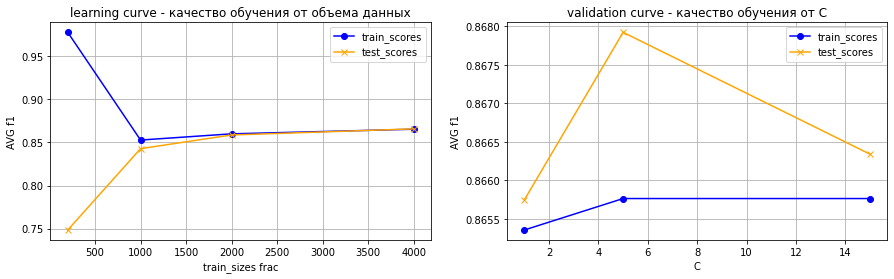

In [94]:
model = LogisticRegression()
res = ml.get_learning_and_validation_curve(model, X, y, 
                                           param_name='C', 
                                           param_range=[1, 5, 15], # для кривой валидации
                                           train_sizes=[0.05, 0.25, 0.5, 1] # для кривой обучения
                                           )

<u>Поиск оптимальных гиперпараметров</u>  
https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov  
  
Разделяем нашу выборку на финально-валидационную X-final-test, а также на валидационную часть train/test.  
На валидационной части с помощью кросс-валидации получаем оценки качества модели при разных гиперпараметрах.  
Выбираем оптимальные гиперпараметры - финально валидируем модель на выборке X-final-test, чтобы исключить  
переобучение при переборе гиперпараметров на валидационной части.
  
Методы подбора гиперпараметров:  
1. grid search - полный перебор всех параметров из заданной сетке param1, param2, ...  
Некоторые параметры можно перебирать в логарифмической шкале чтобы быстрее определить масштаб значения.  
Наиболее точный, но долгий способ оптимизации
2. random search - перебираем случайным образом K заданных точек из пространства параметров.  
Получаем примерную оценку эффекта в разных областях параметрического пространства, сокращаем время подбора.  
https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search  
При этом можно выбирать разные случ. распределения для разных гиперпараметров.  
3. Древесные и байесовские оптимизаторы - используют результаты предыдущих оценок, чтобы прогнозировать  
в какой области сетки параметров с большей вероятностью будет находиться оптимум.  
Сначала делается "разогрев" или разведка через random search с заданными случ. распределениями - затем эта  
информация используется для решений "в какую сторону идти и делать больше замеров".  

In [112]:
model = LogisticRegression()
param_grid = {'C' : [1, 5, 10, 15], 'penalty' : ['l1', 'l2'], 'max_iter' : [100, 500]}
# функция для оценке лучших гиперпараметров через grid или random search
ml.hyper_params_search(model, X, y, param_grid)

{'best_params': {'C': 5, 'max_iter': 100, 'penalty': 'l2'},
 'best_score': 0.867921453438621}

#### Feature encoding. Normalization

https://scikit-learn.org/1.5/data_transforms.html  
https://habr.com/ru/companies/ods/articles/325422/  
https://habr.com/ru/companies/ods/articles/326418/  


<u>Типы признаков</u>  
Пусть мы имеем размеченный датасет X,y. 
Однородные специфические признаки = тексты, звук, видео, гео и.т.д  
Для них существуют свои системы кодирования, здесь обсуждать не будем (больше относится к нейросетям)  

Неоднородные обобщенные признаки = статистические признаки семплов, описываемые таблицей строк/чисел.  
Их можно разделить на следующие типы:  
1. Категориальные номинальные (nominal, нельзя делать арифм. операции и сравнивать: регион клиента)
2. Категориальные порядковые (ordinal, нельзя делать арифм. операции, можно сравнивать: номер курса в университете)
3. Числовые (numerical, можно делать арифм. операции и сравнивать: объем выручки за год; дискретные, непрерывные)

В отличие от числовых признаков, для категориальных не работает арифметика, значит их нельзя в сыром виде  
оптимизировать через функцию потерь и в целом использовать в модели для оценки таргета - нужно кодирование.  
  
---
<u>Кодирование категориальных переменных</u>  
Т.е маппинг категории на числовую переменную. В зависимости от задач выделяют разные способы  
Здесь рассмотрим методы из <u>sklearn.preprocessing</u>

1. Ohe = one hot encoding.
Замена <u>номинального</u> признака x=(a,b,c) тремя признаками x_a=(1,0,0), x_b=(0,1,0), x_c=(0,0,1)  
Можно через df = pd.get_dummies(df, columns=cols) или ohe = OneHotEncoder()  
ohe.fit(x) запоминает базис ohe-колонок по x -> ohe.transform(r) не будет зависеть от наполнения r.  
  
  
2. Кодирование номинальных переменных-классов (например, кошка->1, собака->2 ...)  
Имеет смысл <u>исключительно для таргетов</u> - маппинг в классы, можно через replace или le=LabelEncoder()  
le.fit({a,b,c}) мапит каждому классу последовательную числовую метку, transform применяет ее на всю выборку  
т.е a=1, b=2, c=3  

  
3. Кодирование порядковых переменных (первый -> 1, второй -> 2, ...)  
Здесь мы можем явно определить порядок нумерации и использовать OrdinalEncoder(categories={{a, 1}, {b, 2}})    
Порядковые переменные (например: младший специалист, специалист, старший специалист) правильно кодировать  
последовательными числами (0, 1, 2) - допускает сравнение, минимизируем значимость расстояния.  
  
  
4. Замена категориальной переменной ее статистикой по таргету  
Например, заменяем переменную "регион" значением "ср значение таргета для данного региона".  
Полезно для линейных моделей и бустингов, не имеющих встроенной обработки категориальных переменных.  
Для этого можно использовать te = TargetEncoder() 
(!) targetEncoder является полезной методикой при работе с большим кол-вом категорий - так мы лучше  
транслируем модели связь признака с таргетом. При малом числе категорий это не имеет смысла и лучше  
использовать ohe. При использовании targetEnc важно следить за переобучением, так как при небольшом кол-ве  
данных модель может через такую фичу подстроиться под таргет. Можно использовать smoothed технологию  
для снижения влияния редких категорий (где фича практически равна таргету)
  
---
<u>Нормализация</u>  
Это процесс масштабирования данных в X в фиксированный диапазон {a,b}, подразумевающий смещение и сжатие данных,  
одинаковым образом, чтобы сохранить относительные свойства признаков. Также может подразумевать изменение  
распределения признаков (например, логарифмирование или применение др. преобразований f(x))  
Применяется для ускорения сходимости и точности работы некоторых ML моделей.  
К этому чувствительны линейные и метрические модели (вроде knn), древесные модели больше про ранги,  
поэтому не сильно зависят от нормализации данных.  
К выбросам бустинги также имеют хорошую чувствительность, но сильные выбросы лучше фильтровать заранее.  
  
- MinMaxScaler = (x-x_min)/(x_max-x_min) - полезно для выравнивания порядков величин и улучшения сходимости  
- StandardScaler = (x-mean)/std - для примерно нормальных данных, регрессий, детекций аномалий  
- MaxAbsScaler = x/abs(x) = (-1,1) - сохранение отриц. значений, более мягкий чем MinMax  
- RobustScaler = (x-median)/iqr - масштабирует по перцентильному размаху (задается), полезно при выбросах  

---
<u>Заполнение пропусков</u>  
Пусть некоторый признак A содержит пропуски в данных Null. Тулзы в либе sklearn.impute.  
Две стратегии заполнения пропусков:  
1. На базе информации из самой A. Для числовых: заполнение средним, медианой, константой (типа 0)  
Для категориальной: выделение отдельного столбца is_null, заполнение самым частым.  
Для деревьев можно помечать это значение (вроде -999), чтобы оно выделяло это ранговым образом.  
Можно использовать SimpleImputer либо fillna через pandas  
2. На базе всего датасета - пробуем предсказать, какое значение должно быть на этапе пропуска.  
Используются разные предикторы, в том числе kNN. См KNNImputer, IterativeImputer    

---
**Важно!**  
Кодирования и нормализации правильно применять в одном базисе к тесту и контролю, чтобы не вызвать  
смещения результатов. Поэтому обучаем clf.fit_transform(train) -> clf.transform(test) либо  
делаем преобразование в полном датасете ДО разделения на тест и контроль.  
  
Для catboost нормализация и кодирование номинальных признаков не требуются.  
Древесные алгоритмы мало чувствительны к масштабу данных (так как используют их ранговость),  
catboost также имеет встроенную поддержку номинальных признаков, нужно лишь указать в cat_features.   
Аналогично, нет чувствительности к типу распределения данных (ненормальность итд).  
Полиномиальные преобразования также не нужны и скорее замедляют работу ансамбля.  
Единственное: можно обработать очень сильные выбросы + перевести в числа порядковые признаки.  
  
Catboost умеем работать с заполнением пропусков, однако дефолтное поведение может быть хуже, чем  
более умные модели обработки данных. Можно протестировать два подхода и сравнить производительность.  

In [15]:
# КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ
df = pd.DataFrame({'color_nominal' : ['red', 'red', 'blue', 'black'], 
                   'segment_ordinal' : ['small', 'small', 'medium', 'big'],
                   'revenue_numerical' : [100, 120, 90, 130],
                   'y_class_target' : ['a', 'b', 'b', 'c']})

# OHE номинальных. drop_first полезен для устранения лин. зависимости если в колонке все значения базиса
df = pd.get_dummies(df, prefix=['color'], prefix_sep='_', columns=['color_nominal'], drop_first=False)
display(df)

# Кодирование таргета. Либо изначально .fit([a1, a2, a3]) чтобы установить последовательность 
df['y_encoded'] = LabelEncoder().fit_transform(df.y_class_target)
display(df)

# Кодирование порядковой переменной - заменяем на порядковые целые числа
# указываем корректный порядок; на fit подаем только колонки, объявленные в categories
encoder = OrdinalEncoder(categories=[['small', 'medium', 'big']]) 
df['segment_encoded'] = encoder.fit_transform(df[['segment_ordinal']])
df

,segment_ordinal,revenue_numerical,y_class_target,color_black,color_blue,color_red
0,small,100,a,0,0,1
1,small,120,b,0,0,1
2,medium,90,b,0,1,0
3,big,130,c,1,0,0


,segment_ordinal,revenue_numerical,y_class_target,color_black,color_blue,color_red,y_encoded
0,small,100,a,0,0,1,0
1,small,120,b,0,0,1,1
2,medium,90,b,0,1,0,1
3,big,130,c,1,0,0,2


,segment_ordinal,revenue_numerical,y_class_target,color_black,color_blue,color_red,y_encoded,segment_encoded
0,small,100,a,0,0,1,0,0.0
1,small,120,b,0,0,1,1,0.0
2,medium,90,b,0,1,0,1,1.0
3,big,130,c,1,0,0,2,2.0


In [22]:
# ПРИМЕР НОРМАЛИЗАЦИИ ДАННЫХ - для других скейлеров - аналогично
df[['revenue_numerical_scaled']] = StandardScaler().fit_transform(df[['revenue_numerical']]); df

,segment_ordinal,revenue_numerical,y_class_target,color_black,color_blue,color_red,y_encoded,segment_encoded,revenue_numerical_scaled
0,small,100,a,0,0,1,0,0.0,-0.632456
1,small,120,b,0,0,1,1,0.0,0.632456
2,medium,90,b,0,1,0,1,1.0,-1.264911
3,big,130,c,1,0,0,2,2.0,1.264911


#### Feature engineering

https://www.kaggle.com/code/ryanholbrook/creating-features

Различные модели могут выучивать разные виды закономерностей и требуют разных агрегаций над фичами.  
<u>Общие рекомендации</u>
1. Признаки должны опираться на доменную область и иметь бизнесовую логику - так проще искать связь с таргетом
2. Линейные модели и сети хорошо учат линейные комбинации на суммах/разностях, но другие нелинейные виды  
нужно моделировать (например через полиномиальные признаки) самостоятельно
3. Линейные и метрические модели выигрывают от нормализации данных, обработки выбросов
4. Древовидные модели менее чувствительны к этому и учат любые виды взаимодействия фичей, но  
на ограниченном числе данных полезно подчеркивать явные комбинации фичей X_new = f(X1, X2, ...)
5. Древовидные модели выигрывают от использования agg_count, так как принимают решения на каждом сплите по  
одному признаку и не смотрят на несколько признаков в одном сплите одновременно. Счетчики здесь - это  
частоты встречаемости разных признаков, а также axis=1 агрегации (типа заполнена хоть одна из колонок)  

---
<u>Функциональные преобразования</u>  
Некоторые модели (вроде линейных) чувствительны к типу распределений признаков X (лучше - нормальное).  
Если есть возможность преобразования признака заменой переменных - это улучшает качество.  
Например, логнормальный признак X -> X_new = np.log(X) = нормальный признак.  
Есть обобщенные трансформации типа Бокса-Кокса (от 1 до логарифма = управляем выправлением распределения).  

---
<u>Полиномиальные признаки</u>   
Если мы работаем с признаками x1, x2, x3 ... и используем линейную модель, то она не способна уловить  
нелинейные зависимости вроде x1^n, x1 * x2 * ... - поэтому мы можем включить их в модель отд. признаками   
PolynomialFeatures(degree=N, include_bias=False).fit_transform(df{source_features})  
Полиномиальные признаки + регуляризация улучшают перфоманс линейных моделей.  

---
https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means  
<u>Кластеризация</u>  
По аналогии с бинаризацией признака X (когда разбиваем его на категориальные бины dx1, dx2, ...)  
кластеризация помогает проводить бинаризацию в многомерном пространстве (квантизация вектора X).  
Модель учит не сложную взаимосвязь между признаками X, а категориальную кластерную переменную используя  
метрические знания о пространстве семплов (стратегия - разделяй и влавствуй)

https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

Использование PCA для выявления скрытых паттернов в исходных признаках (про PCA см след раздел).  
Главные компоненты PCA - это линейные комбинации исходных признаков - новая система координат.  
  
Во первых можно спроецировать все в пространство n=2 (пусть и с потерей данных) и поискать аномалии  
(более точно это можно делать использовать методы вродк umap)  
  
Кроме того, можно для важных главных компонент - оценивать, как они связаны (лин. коэффициентами) со  
старой системой координат признаков f1, f2, ...

In [204]:
# генерация данных с разными зависимостями
y = np.random.choice([1,2,3,4, 5], 60, replace=True)
inc = np.random.choice([1, 2,3,4,5], 60, replace=True)
df = pd.DataFrame({'y' : y, 'x1' : y**2 + 15, 'x2': 2 * y + 13, 'x3' : y+inc, 'x4' : inc})
dfx = df.drop(columns='y')

df_relation, dfx_pca = ml.get_pca_and_features_relation(dfx)
df_relation

,PC1,PC2,PC3,PC4
x1,-0.562806,0.340030,0.753412,0.000000e+00
x2,-0.566612,0.333051,-0.573578,4.889135e-01
x3,-0.559441,-0.361421,-0.254791,-7.010578e-01
x4,-0.221869,-0.801768,0.196115,5.191162e-01
evr,0.656512,0.338322,0.005166,8.750303e-33


#### Понижение размерности. PCA, TSNE, UMAP

Имеем датасет X с признаками x1, x2, ... x_n  
Выборка из n семплов и размеченного таргета y. Модель анализирует <u>изменчивость</u> семплов друг  
относительно друга в зависимости от изменчивости таргета - ищет закономерности и формирует предикт.  
Таким образом - информация для модели = мера отличий одних семплов от других, содержащаяся в признаках.  
  
<u>Изменчивость</u> = дисперсия объектов выборки в соответствующей системе координат признаков.  
Изменчивость показывает степень различия объектов друг от друга.  
Для независимых оординат x1, ... x_n: var(x) = var_x1 + ... + var_x_n

Разделим изменчивость у признаков на разные типы:

1. Полезная изменчивость - оказывает важное для модели влияние на таргет, помогая предикту.  
2. Неинформативная изменчивость - не имеет полезной связи с таргетом (курс валюты на время заката)  
3. Отсутствие изменчивости - признак слабо меняется между семплами - не дает информации для модели.  
  
Признаки могут быть коррелированы, давать лин. комбинации, содержать мало дисперсии (в пределе, вообще константа)   
Больше избыточных признаков - размытие точности модели + повышение вычислительной сложности.    
Для линейных моделей это вообще приводит к сингулярности, приходится жертвовать точностью через регуляризацию.  
  
<u>Понижение размерности</u> - смена координат-фичей x1, x2, ... x_n -> z1, z2, ... z_m, где m < n  
При таком переходе теряется часть изменчивости std(z) < std(x).  
Цель: найти такие координаты z, чтобы минимизировать эту потерю.  
  
Пример: у нас есть два признака x1, x2. x2 = k * x1 + b;  
можно повернуть оси на arctg(k) и прийти к истории, когда   
z2=0; z1 - переменная варьирующаяся вдоль оси. Снизили кол-во переменных.  

---
<u>PCA</u>  
PCA = principal component analysis  
Пусть у нас есть исходные признаки x1, x2, ... xn имеющие суммарную вариацию var (по выборке = датасету).  
PCA находит новые оси z1, z2, ... zn по принципу: вдоль z1 наблюдается максимальная дисперсия данных.  
z2 - максимизирует оставшуюся часть вариации итд. Таким образом z1, z2, ... в порядке значимости информации.  
Используются собственные значения матрицы признаков.  
Процедура находит оптимальный набор координат для, но является вычислительно долгой для больших размерностей.  
Далее, убирая последние по значимости признаки zn, zn-1 итд осуществляется понижение размерности с  
максмимальным сохранением итоговой вариации var в пониженном пространстве.
Дополнительно: PCA находит систему наименее коррелирующих между собой признаков.  

Плюсы PCA: убирает избыточные признаки, хорошо для кластеризации и методов обучения, в которых физ. смысл  
новых признаков не имеет значения  
Минусы PCA: в древесных моделях теряется физ. смысл признаков и работа с их важностью; при большой потере  
общей изменчивости - скажется на качестве работы модели.  
  
PS. флаг whiten=True дополнительно осуществляет нормализацию полученных pca-компонент, что полезно для  
алгоритмов чувствительных к масштабу. Но при этом теряется часть объясненной дисперсии  

---
<u>Random Projection</u>  
Метод понижения размерности матрицы признаков X построенный на генерации случайных матриц.  
Основная идея - при понижении размерности, расстояние между данными сохраняется.  
Генерируется множество нормально распр. случайных матриц меньшей размерности (проекции) и каждая точка  
начального пространства переводится в более низкое через них.  
Благодаря рандомизации относительная структура данных примерно сохраняется.  
Метод быстрее чем PCA, но немного менее точный (убирает больше изменчивости при M=const)  
from sklearn.random_projection import GaussianRandomProjection

---
**!!!** При сохранении кол-ва компонент N изменчивость не меняется. Это связано со свойствами дисперсии.  
При снижении кол-ва компонент M < N изменчивость может только снижаться. Чем меньше M новой системы -  
тем меньше дисперсии сохраняется. Можно использовать метод локтя для контроля доли сокращенной изменчивости  
признаков (лучше оставлять >90%)

**!!!** Для PCA необходима нормализация данных, так как алгоритм поворота осей чувствителен к относительному  
масштабу признаков.Нормализация данных не влияет на их общую изменчивость (хотя в абсолютах меняется масштаб) 
  
**!!!** Для catboost это может быть нецелесообразно, если хватает вычислительных ресурсов, так как  
платим снижением объясненной дисперсии, а также потерей физического смысла фичей.  
Нужно применять только если оптимизируем проивзодительность.  

общая изменчивость данных 4.5424706666666665
Оптимально будет взять три компоненты: потеря дисперсии = 0.9581320720000164
Потеря дисперсии при нормализации компонент = 0.4966666666666662


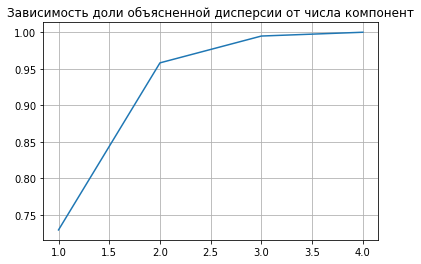

In [40]:
from sklearn.decomposition import PCA
 # тестовый датасет
df = load_iris()
df_x = df['data']; y = df['target']
print('общая изменчивость данных' , df_x.var(axis=0).sum())

# подбор PCA по методу локтя
X = StandardScaler().fit_transform(df_x)
# X = df_x.copy()
explained_variance = []
components_range = range(1, X.shape[1] + 1)  # 1-N

# зависимость доли объясненной дисперсии от кол-ва компонент
for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))
    # прямой способ расчета доли потерянной дисперсии:
    # pca.transform(X).var(axis=0).sum() / X.var(axis=0).sum()

pca = PCA(n_components=2); pca.fit(X)
print(f"""Оптимально будет взять три компоненты: потеря дисперсии = {pca.transform(X).var(axis=0).sum() / X.var(axis=0).sum()}""")
pca = PCA(n_components=2, whiten=True); pca.fit(X)
print(f"""Потеря дисперсии при нормализации компонент = {pca.transform(X).var(axis=0).sum() / X.var(axis=0).sum()}""")  
    
plt.plot(components_range, explained_variance)
plt.title('Зависимость доли объясненной дисперсии от числа компонент')
plt.grid()


Зависимость EVR от кол-ва признаков
Изначальная размерность датасета (1797, 64)
Чтобы evr=0.95 необходимо 40 фичей
MLE дает довольно консервативное срезание 61, evr=1.0


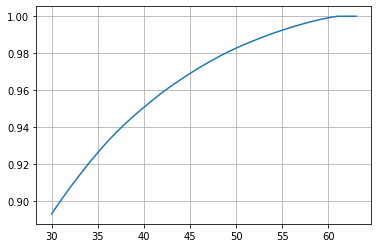

In [49]:
# применение метода из ml-tools
from sklearn.datasets import load_digits
df = load_digits()
df_x = df['data']; y = df['target']
components_range = list(range(30,64,1))
X_transform, evr_095, df_evr = ml.apply_pca(df_x, n_components_range = components_range, n_components=0.95)
X_transform_mle, evr_mle, _ = ml.apply_pca(df_x, n_components='mle')
print(f"""
Зависимость EVR от кол-ва признаков
Изначальная размерность датасета {df_x.shape}
Чтобы evr={np.round(evr_095, 2)} необходимо {X_transform.shape[1]} фичей
MLE дает довольно консервативное срезание {X_transform_mle.shape[1]}, evr={evr_mle}""")
plt.plot(df_evr.n_components.values, df_evr.evr.values); plt.grid()

<u>Метод T-SNE (t-distributed stochastic neighbor embedding)</u>  
Метод понижения размерности фичей для семплов с N -> M с сохранением относительных  
расстояний между фичами. Тип расстояния (по умолчанию, евклидово) можно задавать через опцию metric  
До скольки понижать размерность - отвечает параметр n_components  
  
**!!!** Рекомендуется перед этим снизить размерность через PCA до более адекватных чисел (<50)  
для снижения шума работы алгоритма и скорости его работы (очень энергозатратный).   

Text(0.5, 1.0, 't-SNE визуализация цифр MNIST')

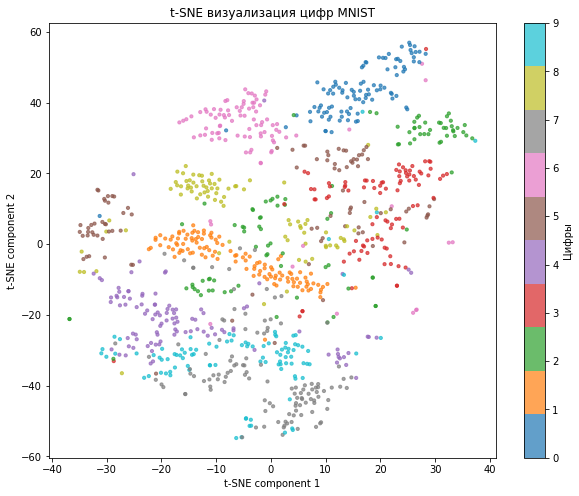

In [69]:
from sklearn.datasets import fetch_openml

# # Загрузка данных MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)
# Уменьшаем размер выборки для ускорения t-SNE
X_sample, y_sample = X[:1000], y[:1000]

# мапим в 2-мерное пространство
X_map = ml.apply_2d_map(X_sample, y_sample, model_type = 'tsne')

# Визуализация t-SNE в 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_map[:, 0], X_map[:, 1], c=y_sample, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Цифры")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE визуализация цифр MNIST")

<u>UMAP = Uniform Manifold Approximation and Projection</u>  
https://umap-learn.readthedocs.io/en/latest/parameters.html  
Аналог t-sne построенный на графовых вычислениях ближайших соседей для аналогичного  
понижения размерности с сохранением дистанции для многомерных датасетов  
  
Считается более продвинутым и лучше сохраняет нелинейные взаимосвязи в данных чем T-SNE

Text(0.5, 1.0, 'UMAP визуализация цифр MNIST')

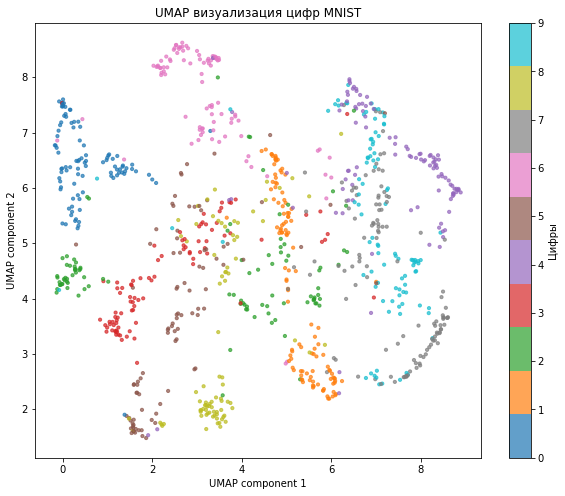

In [68]:
# мапим в 2-мерное пр-во
X_map = ml.apply_2d_map(X_sample, y_sample, model_type = 'umap')

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_map[:, 0], X_map[:, 1], c=y_sample, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Цифры")
plt.xlabel("UMAP component 1")
plt.ylabel("UMAP component 2")
plt.title("UMAP визуализация цифр MNIST")

#### Feature selection

<u>Feature selection</u>  
Помимо снижения кол-ва избыточных признаков с сохранением общей дисперсии данных,  
можно также убирать признаки содержащие неинформативную дисперсию (которая не помогает модели).  
Набор таких признаков лежит в <u>sklearn.feature_selection</u>
  
Если у нас есть датасет X,y - то мы можем выделить наиболее значимые признаки для модели, а остальные убрать.  
Способы выделения значимости признаков делятся на одномерные и многомерные (признаки в комбинациях)

<u>Одномерные (univariate)</u>  
1. Через корреляцию - np.corrcoef(X, Y) - но слабость метода в оценке только линейных зависимостей
2. Через стат-тесты. Можем оценить насколько вариативность признака связана с вариативностью таргета -  
используя ANOVA (см нотбук "Статистика", критерий значимости различия средних между группами)  
Признаки не приводящие значимых различий в средних таргета - исключаются. Хорошо работает для классификации  
где оцениваем зависимость бина признака и среднего значения класса.  
Можно использовать также хи-кв, t-test для оценок - см класс SelectKBest, SelectPercentile
3. Через mutual information (см в этом разделе ниже) - метод на энтропии позволяющий оценивать зависимость  
между X и Y проивзольной формы

Минусы одномерных методов - не оценивают признаки X1, X2, ... в связке. Признаки по одиночке могут иметь мало  
значимости, но начать работать в комбинациях. Более долгие но точные - многомерные методы 
  
---
<u>Mutual information</u>  
https://www.kaggle.com/code/ryanholbrook/mutual-information  
    
---
При оценки приоритетов новых признаков - можно пробовать оценить насколько от данных признаков зависит таргет.  
Если зависимость отсутствует, то признак будет бесполезен для обучения модели.  
Коэф. корреляции полезен, но показывает только линейную взаимосвязь (частный случай)
  
Более общий инструмент - Mutual Information (MI) = насколько знание о переменной X увеличивает знание  
о переменной Y (общая функция взаимосвязи X, Y).  
MI = SUM_xy(p(x,y) * log(p(x,y)/p(x)p(y))   
Здесь p(x), p(y) - вероятности = частоты появления значений переменных x, y  
p(x,y) = частота появления пары x,y в датасете (= совместная вероятность)  
  
!!! Формула выводится из концепции MI = S(X) - S(X|Y) = чистая энтропия X - энтропия при условии Y.  
Т.е мы оцениваем как меняется мера информации, когда добавляем в систему знание про Y.
  
Реализация расчета MI в sklearn позволяет работать с дискретными и непрерывными величинами, эмулируя распределение вероятностей p(x, y). Оценку можно вести через kNN - находим для каждой точки K соседей, оцениваем в каком это  
радиусе - плотность po = 1/r (т е прям физически по плотности точек оцениваем распредление)  
PS. Если значения X - дискретные, то p(x,y) вычисляется прямо и здесь не нужен kNN.  
Для проблемы одинаковых расстояний в KNN используется случайный шум в X - поэтому для стабильного вывода надо фиксировать random_state. mutual_info_classif - для дискретного <u>таргета</u>,  
а mutual_info_regression для непрерывного. При этом в обеих сценариях X - может содержать непрерывные признаки.     Дискретность можно задавать через опцию  discrete_features  

<u>Применимость MI</u>  
1. MI помогает оценить изолированно информативность X для понимания Y (оценивает любые взаимосвязи)
2. При этом НЕ учитывает, что в связке X+Z+... могут иметь объясняющую способность для Y (MI = univariate)
3. В зависимости от модели признак может иметь разную значимость - не обязательно высокую (т.е MI = потенциал)

In [168]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
# генерация данных с разными зависимостями
y = np.random.choice([1,2,3,4, 5], 60, replace=True)
inc = np.random.choice([1, 2,3,4,5], 60, replace=True)
df = pd.DataFrame({'y' : y, 'x1' : y**2 + 15, 'x2': 2 * y + 13, 'x3' : y+inc, 'x4' : inc})
dfx = df.drop(columns='y')

# оценки через регрессию (непрерывный таргет) и классификацию (дискретный)
mi_regr = pd.DataFrame({'features' : dfx.columns, 'mi': mutual_info_regression(dfx, y, random_state=1)})
mi_class = pd.DataFrame({'features' : dfx.columns, 'mi': mutual_info_classif(dfx, y, random_state=1)})
display(HTML(f"<div style='display: flex;'><div style='margin-right: 20px;'>{mi_regr.to_html()}</div><div>{mi_class.to_html()}</div></div>"))

,features,mi
0,x1,1.397399
1,x2,1.290494
2,x3,0.189925
3,x4,0.000000
,features,mi
0,x1,1.630510
1,x2,1.630510
2,x3,0.182089
3,x4,0.000000


In [171]:
# объединенная функция для комплексного анализа
ml.get_univariate_target_relation(dfx, y)

,features,mi,corr_pearson,corr_spearman_rang,anova_pval,anova_is_feature_useful
0,x1,1.630510,0.980687,1.000000,0.000000e+00,1
1,x2,1.630510,1.000000,1.000000,0.000000e+00,1
2,x3,0.229661,0.713190,0.713857,4.470862e-08,1
3,x4,0.000000,0.029260,0.023816,9.935538e-01,0


<u>Многомерные методы фильтрации признаков</u>  
1. Через feature_importance признаков на обученных моделях, которые предоставляют эту оценку.  
Например древесные алгоритмы по ср. высоте признака в ансамбле оценивают его важность для предикта.  
Также модели вроде логистической регрессии в классификации могут делать оценку по вероятности.  
Просто убираем фичи с низкой важностью, оцениваемые моделью
  
2. Иттеративные методы фильтрации признаков.  
Мы просто можем начать перебирать комбинации признаков (разными способами) и через кросс-валидацию  
находить наилучшую комбинацию, содержащую фиксированное кол-во компонент.  
<u>Sequential Feature Selection</u> - когда иттеративно убираем по 1, 2, ... M признаков из набора,  
двигаясь в сторону оптимизации скора (вычислительно долгая история - работает на легких моделях).  
<u>Recursive Feature Elimination</u>  - рекурсивный отбор признаков построенный на feature_importance  
Учим модель - убираем наименее важный признак, опять учим - убираем следующий итд.  
RFE менее долгий чем SFS (RFE = число обучений = числу фильтраций M, SFS = число всех комбинаций N-M признаков)  
Расширенная версия RFECV - обучение, фильтрация менее значимых признаков, оценка перфоманса по кросс-валидации,  
продолжение фильтрации при условии что перфоманс не стал ниже изначально заявленного.  
Полученные данные затем можно извлечь из датасета rfecv.cv_results_  
RFECV более качественно подходит к оценке количества фильтруемых фичей, чем RFE, но и более вычислительно долгий. 

In [97]:
# ПРИМЕР ИСПОЛЬЗОВАНИЯ RFECV
X, y = make_regression(n_samples=1000, n_features=20, noise=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# первичное обучение модели
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"""До RFECV: кол-во признаков {X_train.shape[1]}, mse = {mse}, r2 = {r2}""")

# применение RFECV
min_features_to_select = 15
cv = 5
selector = RFECV(estimator=model, 
                 step=1,
                 cv=cv, 
                 scoring='r2',
                 min_features_to_select=min_features_to_select,
                verbose=0)
selector = selector.fit(X_train, y_train)


idx = selector.support_ # маска выбранных признаков в режиме True/False, arr
nf = selector.n_features_ # сколько фичей в итоге было выбрано
# f_names = feature_names_in_ # когда на входе df, имена фичей

# результаты скоринга для кол-ва фичей от min_features_to_select до n, средние по cv
scores_stat = selector.cv_results_['mean_test_score'] 

# сколько раз в процессе обучалась модель
model_learning_cnt = (X_train.shape[1] - min_features_to_select + 1) * cv
print(f"""model learning cnt = {model_learning_cnt}""")


# фильтрация признаков
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# обучение на очищенном датасете
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"""После RFECV: кол-во признаков {X_train_selected.shape[1]}, mse = {mse}, r2 = {r2}""")

До RFECV: кол-во признаков 20, mse = 0.27294103109782014, r2 = 0.9999888268398571
model learning cnt = 30
После RFECV: кол-во признаков 17, mse = 0.27086390252220877, r2 = 0.9999889118695433


#### Кластеризация

https://education.yandex.ru/handbook/ml/article/klasterizaciya  
  
Задача кластеризации - присвоить каждому семплу датасета X метку кластера так, чтобы оптимизировать метрики  
качества кластеризации (обычно построенные на связности множеств, см далее)  
  
---
<u>K-MEANS</u>   
Наиболее популярный метод для примерно сферических (не кольца) компактных кластеров. Алгоритм:
1. Выбираем K начальных точек признакового пространства, распределяем все семплы по принципу ближайшего  
2. Пересчитываем центры кластеров исходя из среднего арифметического векторов всех семплов
3. Переопределяем семплы по принципу 1 (пересчитываем кластера)
4. Повторяем шаги 1-3 пока изменение позиции кластеров после пересчета не станет меньше, чем delta
  
Особенности инициализации центроидов (центров кластеров):
1. В качестве первого центроида берем случайный семпл из X (чтобы не уйти очень далеко от множества)  
2. Другие центроиды выбираем случайно, вероятность выбора p ~ r^2 - чем дальше центры кластеров друг от  
друга, тем лучше (иначе будет кучная инициализация и плохая сходимость)
  
Пересчет центроидов (центров кластеров) идет по среднему арифметическому расстояний до точек кластера.  
Оптимальная сходимость для евклидова расстояния, но можно использовать другие (но без оптимальности сходимости)
  
Для фиксированного K минимизирует инерцию (см ниже метрики кластеризации).  

PS. Скорость работы алгоритма s ~ N * d, где N - кол-во семплов, а d - кол-во признаков.  
Снижение N на каждом шагу возможно через mini-batch, снижение d можно проводить через предварительное  
понижение размерности признаков (см главу выше "понижение размерности"), например PCA.  

Mini-batch K-means: на каждом шаге алгоритма производим пересчет центроидов на случ. подвыборке X. 
Итоговая скорость сходимости центроидов растет по аналогии с стохастическим градиентным спуском.  
  

  
PSS. Квантизация признаков - когда признаков очень много, можно выполнить задачу кластеризации (K=500-1000), а  
затем использовать попадание в кластер, как самостоятельным признаком (тоже вид сокращения размерности) -  
например для последующего обучения моделей  
  
Поиск K: по методу локтя - перебирая различные K и оценивая в какой момент инерция F станет достаточно  
малой и дальше будет уменьшаться незначительно с ростом кол-ва кластеров (в пределе когда K=n, F=0)
  
---
<u>ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ</u>  
Агломеративные алгоритмы = начинаем с большого числа кластеров (например K=n) и постепенно объединяем их до критерия останова. Дивизионные = наоборот, разбиваем большие кластеры до более мелких.  
  
Иерархические алгоритмы = присутствует степень вложенности одних кластеров в другие (иерархия).  
Плоские алгоритмы = кластеры равноправные (описываются плоским списком)  
  
Условия объединения кластеров:    
Объединяем кластер A с максимально близким к нему кластером B. Возможные метрики расстояния r(A,B):  
- среднее, минимальное, максимальное расстояния между всеми парами семплов в двух кластерах
- более экзотические метрики вроде формулы Ланса — Уильямса
  
Возможные условия останова объединения:  
1. достигнуто необходимое кол-во кластеров K
2. перестать объединять кластеры, расстояние между которыми более чем d_max
    
---
<u>DBSCAN = Density-based spatial clustering of applications with noise</u>  

Задаем некоторое значение окрестности r (радиус шара вокруг каждого семпла) а также число семплов N0.  
Все семплы в датасете X разделяются на основные, граничные и шумовые:
1. Основные - в окрестности r находится >N0 точек (довольно много)  
2. Граничные - содержат в окрестности основные точки, но тотал кол-во точек менее N0
3. Шумовые - не содержат в окрестности основные + кол-во точек менее N0
  
Далее кластеризация происходит так:
1. Основные точки с общей окрестностью соединяются ребрами - полученный граф дает кластер
2. Шумовые точки не присваиваются ни к какому кластеру
3. Граничные точки относятся к кластеру, в который попала ее основная точка
  
По гиперпараметрам N0, r: DBSCAN способен сам определить кол-во кластеров  
Минусы: работает довольно долго и сильно замедляется при росте числа признаков d 
  
---
<u>MIXTURE MODELS</u>  

Считаем, что каждый кластер генерирует свое вероятностное распределение семплов (чем ближе к центру, тем выше)  
Обычно выбирают нормальное распределение с неизвестной дисперсией, центрированное по кластеру
Далее вычисляют правдоподобие = вероятность наблюдать текущие значения семплов при заданных распределениях.  
Затем иттеративно меняют параметры распределений, максимизируя правдоподобие

---
<u>СРАВНЕНИЕ АЛГОРИТМОВ</u>  

k-means:
1. требует знания об изначальном кол-ве кластеров (или подбор локтем)
2. работает для примерно компактных и сферических кластеров (не кольца итд)
3. работает за норм время из за батчевой реализации и в условиях понижения размерности признаков
4. чувствителен к выбросам т.к используется среднее

иерархия:
1. работает на кластерах сложной формы (например, кольца)
2. работает быстрее, так как не требует иттеративного пересчета
3. в качестве гиперпараметров для останова требует расстояния до кластеров или их макс. кол-во
4. точность алгоритма не очень высокая

dbscan:
1. требует иттеративной оптимизации по r, N0 гиперпараметрам
2. работает долго и сильно зависит от размерности d
3. достаточно точный и справляется с кластерами сложной формы (например, кольцами)

mixture model:
1. работает с эллиптическими и вытянутыми кластерами, но компактными (т.е шире чем kmeans, но слабее dbscan)
2. требует изначального кол-ва кластеров как и kmeans
3. чувствителен к выбросам т.к используется среднее
4. лучше работает на данных с нормальным распределением
5. медленный, так как требует вычисления правдоподобия на каждом шагу


---
<u>МЕТРИКИ КАЧЕСТВА КЛАСТЕРИЗАЦИИ</u>

<u>Инерция</u>  
Среднекластерное расстояние = ср.расстояние между семплами внутри кластеров / ср. расстояние между всеми семплами  
Если у кластеров есть центры, то в числителе ср. расстояние до центров (аналогичные значения)  
Подходит для примерно сферических компактных кластеров (не сложной формы)
F(x, a_K) = 1/nK * sum((x - a_K)^2) = средний квадрат расстояния объектов x до центров своих кластеров a_K    
F(x, a_K) = инерция кластеров = мера компактности кластера. Чем F меньше - тем более кучно точки вокруг центра 
кластеров. Производная dF/da показывает, что для минимизации F нужно пересчитывать a_k как ср арифметические векторов diff = x - a_K  

<u>Коэффициент силуэта</u>  
Подходит для оценки кластеров сложной формы (но считается дольше инерции)
Для каждого семпла x показывает насколько хорошо он вписывается в свой кластер по сравнению с соседним.  
a(x) = ср. расстояние до точек в своем кластере; b(x) = ср. расстояние до точек в ближ. кластере  
S(x) = (b - a) / max(a, b) = (-1, 1).  
max - нормирует в нужный интервал, S = 1 идеальное описание кластером, S = -1 оч плохо, S = 0 на границе.  
S = avg(S(x)) = оценка качества кластеризации по шкале -1, 1
  
  
<u>Гомогенность и полнота</u>  
Если у каждого семпла X есть **таргет** Y (при этом данных не оч много, чтобы решать классификацию), то  
качество кластеризации можно определить по однородности кластеров по таргетам - как с листьями деревьев.  
Можно использовать индекс Джинни или энтропию = степень гомогенности кластеров

Полнота: тем выше, чем больше семплов одного класса попадают в один кластер.  
Гомогенность и полнота - аналоги точности и полноте в задачах классификации.  
Их взвешенное значение (аналог f-меры): это V-мера кластеризации = ср. гармоническое с весами
  
Задача кластеризации может иметь несколько решений, поэтому есть сложность в точности ее оценки. Варианты:
1. Кластеры примерно сферические, у данных нет разметки: инерция через метод локтя (или др метрики компактности)
2. Кластеры произвольные, нет разметки: минимизация коэффициента силуэта (можно тоже локтем)
3. Имеется разметка в данных: минимизируем V-меру в заивимости от баланса полноты/гомогенности
4. Если используем кластеры, как фичи для обучения - подбираем гиперпараметры оптимизируя метрику обучения

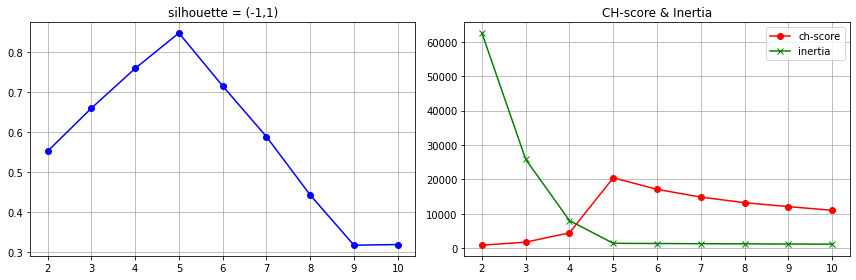

In [83]:
# ПРИМЕР K-MEANS
# генерируем данные с кластерами и фичами
X, _ = make_blobs(n_samples=1000, n_features=4, centers=5, cluster_std=0.60, random_state=0)

sh_list, ch_list, inertia = [], [], []
cl_range = [2,3,4,5,6,7,8,9,10]
for n_cl in cl_range:
    
    _, metrics = ml.find_clusters(X, method='kmeans', n_clusters=n_cl)
    sh_list.append(metrics['silhouette'])
    ch_list.append(metrics['ch_score'])
    inertia.append(metrics['inertia'])
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(cl_range, sh_list, marker='o', color='b')
ax1.set_title("silhouette = (-1,1)")

ax2.plot(cl_range, ch_list, marker='o', color='r')
ax2.plot(cl_range, inertia, marker='x', color='g')
ax2.set_title("CH-score & Inertia")
ax2.legend(['ch-score', 'inertia'])

plt.tight_layout()
ax1.grid(); ax2.grid(); plt.show()

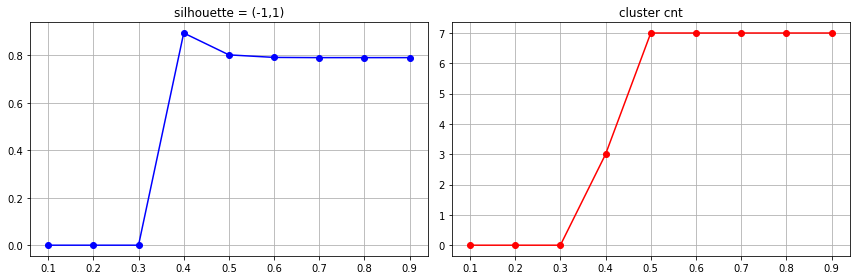

In [109]:
n_features = 10
X, _ = make_blobs(n_samples=1000, n_features=n_features, centers=7, cluster_std=0.80, random_state=0)

# нормализуем данные 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# обычно перебирается в окрестности от 2 * n_features
min_samples = 2 * n_features

# оптимально покрывает возможные расстояния после нормализации, зависит от плотности кластеров
eps_list = list(np.arange(0.1, 1, 0.1)) 

sh_list = []
label_cnt_list = []
for eps in eps_list:
    
    _, metrics = ml.find_clusters(X_scaled, method='dbscan', eps=eps, min_samples=min_samples)
    
    # для удобства графического отображения; по факту - сплошной шум
    if metrics['silhouette'] is None:
        silhouette = 0 
    else:
        silhouette = metrics['silhouette']
    sh_list.append(silhouette)
    label_cnt_list.append([metrics['label_cnt']])
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(eps_list, sh_list, marker='o', color='b')
ax1.set_title("silhouette = (-1,1)")

ax2.plot(eps_list, label_cnt_list, marker='o', color='r')
ax2.set_title("cluster cnt")

plt.tight_layout()
ax1.grid(); ax2.grid(); plt.show()

#### CatBoostClassifier

https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier  
  
Классификатор = градиентный бустинг на решающих деревьях. Каждый лист имеет таргет наиболее частотного класса семплов внутри него, сплитование оптимизируется по критерию Джинни или Энтропии (logloss)
  
В качестве инициализирующих параметров принимает на вход множество, основные их типы:  
1. Базовые параметры (iterations, learning rate, depth, leaf_l2_reg, model_size_reg, rsm=доля случ признаков)  
2. Целевая функция: loss_function и eval_metric (для регрессии могут совпадать - см метрики качества)  
3. Параметры границ и квантования признаков, обработки пропусков, ранняя остановка алго
4. Параметры обработки категориальных признаков (когда использовать ohe, доля в дереве итд)
5. Параметры рандомизации (seed, bagging_temperature = степень случайности семлпирования), методы регулировки бустинга
  
В отличие от регрессора - присутствуют параметры вроде class_weight, другой набор eval_metric и loss_function

---
На этапе fit бустинг поддерживает cat_features - список передаваемых категориальных номинальных фичей (т е нет необходимости использовать ohe или другие методы обработки), а также text_features - заменяя их на текстовые эмбеддинги

In [2]:
# ПОДГОТОВКА ДАННЫХ

# классическая задача о выживших на титанике
df = pd.read_csv('./data/titanic.csv')
y = df.Survived.values

def prep_name(x):
    x = x.replace('Mlle', 'Miss').replace('Ms', 'Miss').replace('Mme', 'Mrs')
    if 'mr.' in x:
        return 'mr'
    if 'mrs.' in x:
        return 'mrs'
    if 'miss' in x:
        return 'miss'
    if 'master.' in x:
        return 'master'
    else:
        return 'name_null'
df['name_type'] = df.Name.apply(str.lower).apply(prep_name)

# рассматриваем как ординальное
# title_mapping = {"mr": 1, "miss": 2, "mrs": 3, "master": 4, "rare": 5}
# df['name_type'] = df['name_type'].map(title_mapping)
# df['name_type'] = df['name_type'].fillna(0)

#
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
df['Age*Class'] = df.Age * df.Pclass

df_x = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'name_type', 
           'Parch', 'FamilySize', 'IsAlone', 'Age*Class']]

# Вариант обработки категориальных фичей через OHE, но для catboost лучше - встроенные методы
# df_x = pd.get_dummies(df_x, columns=['Sex', 'Embarked'])

categorical_columns = ['name_type', 'Sex', 'Embarked']
# df_x = df_x[['name_type']]; categorical_columns = ['name_type'] # проверка на плохих данных

In [14]:
# БЕЙЗЛАЙН
X_train, X_test, y_train, y_test = train_test_split(df_x, y, test_size=0.33)

# инициализируем тренировочную и обучающую выборки
train_pool = ml.get_pool(X_train, y_train, categorical_columns)
test_pool = ml.get_pool(X_test, y_test, categorical_columns)

# инициализируем гиперпараметры модели
params = {
    'depth': 6, # глубина деревьев (больше = сложнее зависимости, но дольше и риск переобуч)
    'learning_rate': 0.03, # шаг изменения параметров при добавлении нового дерева в ансамбль (аналогично depth)
    'iterations': 1000, # количество деревьев в ансамбле
    'l2_leaf_reg': 3, # штраф за большие веса в листьях (аналогично рег. в регрессии)
    'bagging_temperature': 1, # интенсивность рандомизации при бустрапе в ансамбле
    'auto_class_weights': 'Balanced', # автоматически присвоить веса меткам обр. пропорционально частоте
    'random_strength': 1, # рандомизация сплитования (также влияет на переобучение)
    'loss_function' : 'Logloss', # функция потерь которую оптимизиуем при обучении дерева
    'eval_metric' : 'F1', # метрика, которую оптимизирует ансамбль
    'verbose' : False, # не выводить логи с каждой иттерации (можно указать частоту)
#     'silent' : False # полностью отключить вывод логов модели когда true 
}
   
# обучение модели на тестовых данных
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# оценка качества и важность фичей
print(ml.get_model_score(y_test, model.predict(test_pool), model.predict_proba(test_pool)[:, 1]))
pd.DataFrame({'feature' : test_pool.get_feature_names(), 
              'feature_importance' : model.feature_importances_}).sort_values(by='feature_importance',
                                                                             ascending=False).head(5)

{'precision': 0.808695652173913, 'recall': 0.8157894736842105, 'f1-score': 0.812227074235808, 'support': 114, 'accuracy': 0.8542372881355932, 'roc_auc': 0.894155277697005}


,feature,feature_importance
4,Fare,19.591006
6,name_type,16.839020
10,Age*Class,15.118700
5,Embarked,13.122874
2,Age,10.824380


In [260]:
# Кросс-валидация на k фолдах
# https://catboost.ai/en/docs/concepts/python-reference_cv
# fold_count = 3-10; чем выше - тем больше точность модели, но дольше обучение
fold_count = 5
pool = ml.get_pool(df_x, y, categorical_columns)
get_cv(params, pool, fold_count)

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
999,999,0.789177,0.03826,0.966877,0.006496,0.48926,0.07747,0.139636,0.013181


In [160]:
# Оптимизация гиперпараметров
# https://catboost.ai/en/docs/concepts/python-reference_catboost_randomized_search
param_grid = {
    'iterations': [1000, 5000, 10000],
    'learning_rate': [0.01, 0.03, 0.05],
    'eval_metric' : 'AUC:hints=skip_train~false'
}

model = CatBoostClassifier(**params)
pool = get_pool(df_x, y, categorical_columns)

# или model.randomized_search с параметром n_iter
grid_search_result = model.grid_search(param_grid,
                                       X=pool, # или X,y если не создан pool
                                       cv=3, # кросс-валидация на каждом шаге для оценки
                                       plot=False,
                                       verbose=0
                                      )

best_params = grid_search_result['params']

#### CatboostRegressor

https://catboost.ai/en/docs/concepts/python-reference_catboostregressor  
  
Как и классификатор - градиентный бустинг на решающих деревьях. При этом, если в классификаторе в каждом  
листе дерева - наиболее часто представленный класс тренировочной выборки, а оптимизация сплитов - по  
однородности фрагментов (индекс Джинни), то в регрессоре: таргет листа - среднее по семплам внутри него,  
оптимизация по одной из метрик вроде RMSE.  
  
В качестве инициализирующих параметров принимает на вход множество, основные их типы:  
1. Базовые параметры (iterations, learning rate, depth, leaf_l2_reg, model_size_reg, rsm=доля случ признаков)  
2. Целевая функция: loss_function и eval_metric (для регрессии могут совпадать - см метрики качества)  
3. Параметры границ и квантования признаков, обработки пропусков, ранняя остановка алго
4. Параметры обработки категориальных признаков (когда использовать ohe, доля в дереве итд)
5. Параметры рандомизации (seed, bagging_temperature = степень случайности семлпирования), методы регулировки бустинга
  
В отличие от классификатора - отсутствуют параметры вроде class_weight, другой набор eval_metric и loss_function

#### Machine Learning Explainability

https://www.kaggle.com/learn/machine-learning-explainability

Понимание того, на какие признаки и как обращает внимание модель может быть важно для  
улучшенного feature engineering, извлечения бизнесовых инсайтов, контроля ресурсов по получению  
признаков (если к примеру их добыча дорогая).  
  
<u>Permutation importance</u>  
Пусть есть X = x1, x2, ... и таргет y. Мы можем оценить насколько признак x_i важен для модели, если  
поймем насколько сильно падает ее validation_score, если просто сделать random_shuffle(x_i) в датасете.  
Само обучение происходит на оригинальных данных, перемешивание на этапе валидации:
1. model = model.fit(X_train)
2. score_original = score(model.predict(X_test), y_test)
3. score_shiffle_1 = score(model.predict(X_test_shuffle_x1), y_test), ... score_shuffle_N
  
sklearn.inspection.permutation_importance - принимает модель и тренировочный датасет на вход.  
Importance для каждой фичи вычисляется как изменение score модели (shuffle происходит несколько раз,  
далее вычисляется погрешность оцениваемой важности)
  
<u>Prediction Values Change (PVC)</u>  
Метод оценки важности признака x_i для модели через оценку того на сколько изменится model.predict на  
группе семплов если у этой группы сместить x_i на dx (небольшое значение)  
Т.е по сути - это аналог производной для оценки чувствительности модели к признакам.  
Вычислительно менее сложный чем permutation_importance. По дефолту применяется в Catboost.   
  
<u>PDP = Partial Dependence Plots</u>  
https://www.kaggle.com/code/dansbecker/partial-plots  
Инструмент визуализации зависимости среднего предсказания модели от значений признаков x1, x2, ...  
То есть строим зависимость AVG(model.predict) от x1 например, при фиксированных x2, x3, ...  
Пример: модель предсказания дохода от возраста, образования и пр. PDP может показать как меняется доход в  
зависимости от возраста при остальных фиксированных переменных  
!!! PDP аналогичен линейным коэффициентам в логистической регрессии, обобщенным на нелинейные модели.  
 
<u>SHapley Additive exPlanations = SHAP</u>  
https://www.kaggle.com/code/dansbecker/shap-values  
Методика оценки того, как модель принимает решение на <u>конкретном тестовом семпле</u>  
1. Итак, пусть у нас есть семпл s = x1, x2, ... и модель приняла на нем решение model.predict(s) = y_pred  
2. Вычислим baseline predict: простой const-предикт равный среднему таргетов тренировочной выборки y_baseline_pred.
3. y_pred = y_baseline_pred + shap_val1 + shap_val2 + ... , где shap-val_i = вклад в предикт признака x_i  
  
Таким образом, мы видим как каждый признак вносит вклад в финальное предсказание модели.  
shap_val вычисляется перебором всех комбинаций где присутствует признак x_i и оценкой разницы предиктов.  
У него также есть метод tree-модификации, который оптимизирует перебор всех комбинаций вхождений признаков


In [207]:
from sklearn.inspection import permutation_importance
import shap
from catboost import CatBoostRegressor
from sklearn.datasets import fetch_california_housing

# Пример с регрессией - обучаем catboost
data = fetch_california_housing()
X = data.data
y = data.target
feature_names = data.feature_names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
params = {'loss_function' : 'RMSE', 'eval_metric' : 'RMSE', 'verbose' : False}  
model = CatBoostRegressor(**params)
model.fit(X_train, y_train)
ml.get_model_score(y_test, model.predict(X_test), is_clf=False)

{'R^2': 0.8492011667520589,
 'MAE-Mean_Abs_Err': 0.2930902211813113,
 'RMSE-Root_Mean_Sq_Err': 0.4445313768412239,
 'MAPE-Mean_abs_perc_err_%': 16.873865464413775}

In [224]:
# feature importances
dfi = pd.DataFrame(None, columns=['feature'])
dfi['feature'] = feature_names

# дефолтно применяется pvc расчет (aka model.get_feature_importance(type='PredictionValuesChange'))
dfi['importance_PVC'] = model.feature_importances_ # 
dfi['importance_permutation'] = permutation_importance(model, X_test, y_test, scoring='r2', n_repeats=50)['importances_mean']

print('Разные методы расчета ожидаемо сонаправленны')
dfi.sort_values(by='importance_PVC', ascending=False)

Разные методы расчета ожидаемо сонаправленны


,feature,importance_PVC,importance_permutation
0,MedInc,32.236578,0.340510
6,Latitude,21.572013,1.709416
7,Longitude,18.736877,1.536421
5,AveOccup,14.493186,0.134700
1,HouseAge,5.466296,0.039370
2,AveRooms,3.567946,0.077361
3,AveBedrms,2.017315,0.007139
4,Population,1.909789,0.007459


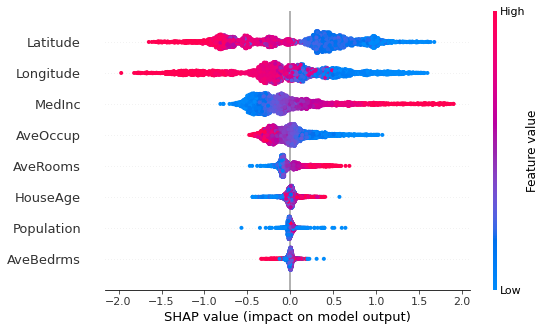

In [228]:
# SHAP - значения показывающие вклад каждого признака в общее предсказание
# Для классификации идет предсказание логита l = log(p / (1-p)); для регрессии - итогового предикта регрессора
# PS. в catboost есть встроенный метод расчета shap (последняя колонка = expectedVals - ср логит по трейну)
# shap_values = model.get_feature_importance(type='ShapValues', data=ml.get_pool(X_test, y_test))
# Здесь shap_vals - это компоненты, сумма которыех равна y_predict
df_test = pd.DataFrame(X_test, columns=feature_names)
shap_vals = ml.get_shap_vals(model, df_test, True)

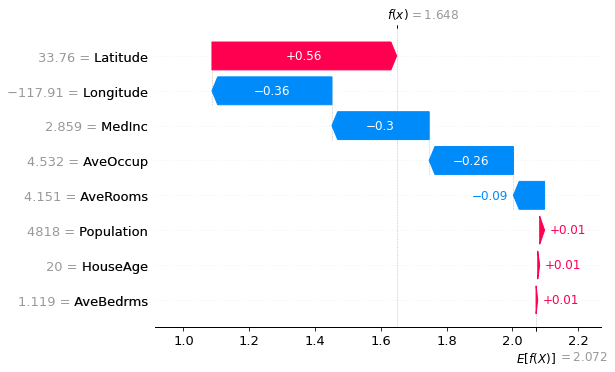

In [190]:
# вклад разных фичей в предикт по конкретному объекту
ml.draw_sample_shap(shap_vals, 12)

In [213]:
# expectedVal = E(f) = dummy-предсказание по среднему от train (логит для классификации, предикт для регр)
np.mean(y_train), shap_values.base_values[0]

(2.071946937378876, 2.071876033253707)

['MedInc', 'HouseAge', 'AveRooms']


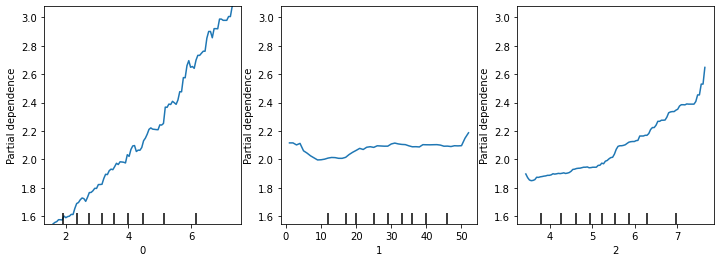

In [244]:
# pdp - изменение предсказания модели при изменениях признаков
df_train = pd.DataFrame(X_train, columns=df_test.columns)
ml.draw_pdp(model, df_train, ['MedInc', 'HouseAge', 'AveRooms'])

#### Imbalanced: over and under-sampling

https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets
https://imbalanced-learn.org/stable/introduction.html

---
Дисбаланс классов влияет на оценку точности и работу алгоритма. Пусть у нас много target=-1 и мало 1.
1) модель оптимизирует accuracy - достаточно часто присваивать target = -1 чаще -> чаще попадаем  
2) модель оптимизирует roc auc = шанс корректно отранжировать два семпла с разными таргетами  
здесь модель может чаще присваивать target = 1, чтобы на всех малочисленных парах (-1, 1) давать верный резалт.  
При этом из за малого кол-ва таких пар семплов - метрика также будет шумная.  
  
Метрика f1 более подходит для оценок, так как учитывает precision и recall, балансируя точность и полноту.  
При этом качество обучения по прежнему будет страдать из за малого миноритарного класса. Для устранения этой проблемы существует ряд методов.  
  
Техники исправления дисбаланса классов.  
<u>Resampling</u>  
under-sampling или over-sampling - добавляем семплы в меньший класс или убираем из большего.  
минус over-sampling - переобучение с учетом роста дублей семплов, надо контролировать.  
uver-sampling снижает точность, так как теряем часть train-информации  
  
Более качественная техника - добавлять семплы с некоторой вариацией, учитывая структуру данных (умная  
синтетика). Это снизит переобучение по сравнению с грубым дублированием.  
SMOTE = Synthetic Minority Over-sampling Technique = с помощью k-means для каждой точки миноритарного  
класса находят ее соседей по классу - генерируем новые точки с координатами между данными  
  
Tomek Links - метод under-sampling. Убираются точки из мажоритарного класса максимально близкие  
к точкам миноритарного (по сути малоинформативные). Это приводит к чистке границы - когда на границе  
классов снижаем число точек большего класса

In [128]:
# Создаем датасет с дисбалансом классов
X, y = make_classification(
    n_samples=3000,           # Общее число образцов
    n_features=10,            # Число признаков
    n_informative=5,          # Число информативных признаков
    n_redundant=1,           # Число избыточных признаков
    n_clusters_per_class=1,   # Число кластеров на класс
    weights=[0.9, 0.1],     # Соотношение классов (дисбаланс)
    flip_y=0.01,              # Доля объектов которым класс приписывается рандомно (шум)
    class_sep = 0.9,         # степень разделимости классов (расстояние между кластерами)
    random_state=42           # Фиксируем для воспроизводимости
)

In [118]:
# смотрим на кластеры в 2D пространстве
def view_clusters(X, y, random_state = 10):
    df_2d = pd.DataFrame(ml.apply_2d_map(X, scaler=True, model_type = 'umap',
                                        n_neighbors=15, min_dist=0.1, random_state=None))
    ax = eda.get_subplots(size = (3, 2))
    eda.make_plot('scatter', {'x' : df_2d[0].values, 'y' : df_2d[1].values, 'hue' : y})

# здесь будем проверять как sampling методы влияют на качество
def check_model_score(X, y, Sampler = None, sampling_strategy = 0.5, random_state = 5):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)
    
    # sampling
    if Sampler is None:
        X_train_s, y_train_s = X_train, y_train
    else:
        # sampling_strategy - len(minor_class) / len(major_class) after sampling
        sampler = Sampler(sampling_strategy = sampling_strategy)
        X_train_s, y_train_s = sampler.fit_resample(X_train, y_train)
    
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test) # предикт на валидационном датасете без семплинга
    y_probability = model.predict_proba(X_test)[:, 1] # вероятность принадлежности к классу 1
    print(ml.get_model_score(y_test, y_pred, is_clf = True, y_predict_probability = y_probability))
    view_clusters(X_train_s, y_train_s)   

{'precision': 0.9264705882352942, 'recall': 0.5526315789473685, 'f1-score': 0.6923076923076924, 'support': 114, 'accuracy': 0.9434343434343434, 'roc_auc': 0.9293489145237523}


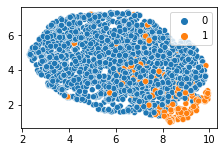

In [132]:
# базовые результаты без применения разделителя
check_model_score(X, y, Sampler = None)

{'precision': 0.7699115044247787, 'recall': 0.7631578947368421, 'f1-score': 0.7665198237885462, 'support': 114, 'accuracy': 0.9464646464646465, 'roc_auc': 0.9388518385003605}


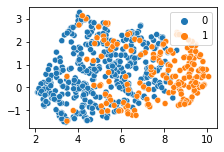

In [131]:
from imblearn.under_sampling import RandomUnderSampler
# рандомно убираем инфу из мажоритарного класса до ratio = sampling_strategy
check_model_score(X, y, RandomUnderSampler)

{'precision': 0.8985507246376812, 'recall': 0.543859649122807, 'f1-score': 0.6775956284153006, 'support': 114, 'accuracy': 0.9404040404040404, 'roc_auc': 0.9409096371064647}


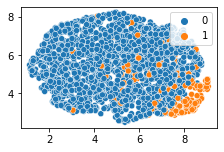

In [133]:
from imblearn.under_sampling import TomekLinks
# убираем пары Томека на границе классов
check_model_score(X, y, TomekLinks, sampling_strategy = 'majority')

{'precision': 0.8777777777777778, 'recall': 0.6929824561403509, 'f1-score': 0.7745098039215685, 'support': 114, 'accuracy': 0.9535353535353536, 'roc_auc': 0.9496615396939838}


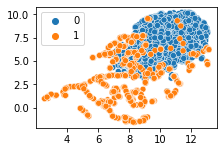

In [136]:
# даем больше точек меньшему кластеру по SMOTE; over_sampling strategy
# точность улучшается - не дропаем лишнюю инфу, добавляем умную дополнительную
from imblearn.over_sampling import SMOTE
check_model_score(X, y, SMOTE)

{'precision': 0.9054054054054054, 'recall': 0.5877192982456141, 'f1-score': 0.7127659574468085, 'support': 114, 'accuracy': 0.9454545454545454, 'roc_auc': 0.943152687655211}


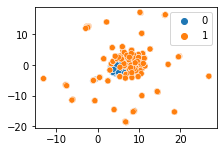

In [138]:
from imblearn.over_sampling import RandomOverSampler
check_model_score(X, y, RandomOverSampler)